In [545]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

# Helper functions

In [546]:
def get_centroid(word_forms, model):
    vectors = [model.wv[word] for word in word_forms if word in model.wv]
    if not vectors:
        return None
    centroid = np.mean(vectors, axis=0)
    return centroid

In [600]:
# def calculate_distance(centroid1, centroid2):
#     return np.linalg.norm(centroid1 - centroid2)
from scipy.spatial import distance
def calculate_distance(centroid1, centroid2):
    return distance.cosine(centroid1, centroid2)


In [384]:
def zerocenter_normalize(model):
    vectors = model.wv.vectors
    vectors = vectors - np.mean(vectors, axis=0)
    vectors = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)
    model.wv.vectors = vectors

    return model

In [376]:
# import json
# file_path = 'all_forms_dict.json'
#
# with open(file_path, 'r') as file:
#     all_forms_dict = json.load(file)

In [382]:
# all_forms_dict['укр']

In [377]:
models_path = '/Users/katerynaburovova/PycharmProjects/dehumanization/w2v_models/models_in_time'

In [378]:
models_path_few_epoch = '/Users/katerynaburovova/PycharmProjects/dehumanization/w2v_models/models_in_time_few_ep'

In [379]:
models_path_more_epoch = '/Users/katerynaburovova/PycharmProjects/dehumanization/w2v_models/models_in_time_more_ep'


In [380]:
def extract_time_period(model_name):
    match = re.search(r'(\d{4}-\d{2}-\d{2})_to_(\d{4}-\d{2}-\d{2})', model_name)
    if match:
        return match.group(1), match.group(2)
    return None, None

In [606]:
import pymorphy2

# def get_word_forms(word):
#     morph = pymorphy2.MorphAnalyzer()
#     if word == 'укр':
#         return ['укр', 'укра', 'укру', 'укром', 'укре', 'укры','укров', 'украм', 'украми', 'украх']
#
#     parsed_word = morph.parse(word)
#     forms = []
#     for parse_result in parsed_word:
#         for form in parse_result.lexeme:
#             forms.append(form.word)
#     forms = list(set(forms))
#     return forms

def get_word_forms(word_or_list):
    morph = pymorphy2.MorphAnalyzer()
    forms = []

    words = word_or_list if isinstance(word_or_list, list) else [word_or_list]

    for word in words:
        if word == 'укр':
            forms.extend(['укр', 'укра', 'укру', 'укром', 'укре', 'укры','укров', 'украм', 'украми', 'украх'])  # replace with actual forms if needed
            continue

        parsed_word = morph.parse(word)
        for parse_result in parsed_word:
            for form in parse_result.lexeme:
                forms.append(form.word)

    forms = list(set(forms))
    return forms


In [548]:
def plot_denotation_divergence_smooth(term_one, term_two, models_path, window_size=5):
    terms_one = get_word_forms(term_one)
    terms_two = get_word_forms(term_two)
    print(terms_one)
    print('*'*80)
    print(terms_two)
    distance_list = []
    time_periods = []

    model_files = sorted(os.listdir(models_path), key=lambda x: extract_time_period(x)[0] if x.endswith('.model') else '')
    for model_name in model_files:
        if not model_name.endswith('.model'):
            continue

        start_date, end_date = extract_time_period(model_name)
        if not start_date or not end_date:
            continue

        model_path = os.path.join(models_path, model_name)
        model = Word2Vec.load(model_path)
        model = zerocenter_normalize(model)

        centroid1 = get_centroid(terms_one, model)
        centroid2 = get_centroid(terms_two, model)

        if centroid1 is None or centroid2 is None:
            continue

        distance = calculate_distance(centroid1, centroid2)
        distance_list.append(distance)
        time_periods.append(f'{start_date} - {end_date}')

    weights = np.repeat(1.0, window_size) / window_size
    smoothed_distances = np.convolve(distance_list, weights, 'valid')

    plt.figure(figsize=(10, 6))
    plt.plot(smoothed_distances)
    plt.xticks(range(len(smoothed_distances)), time_periods[window_size-1:], rotation=90)  # Adjust x-axis labels
    plt.xlabel('Time Periods')
    plt.ylabel('Smoothed Cosine distance')
    plt.title('Denotation Divergence in Time of Terms {} and {}'.format(term_one, term_two))
    plt.tight_layout()
    plt.show()


In [637]:
# import random
# random.seed(42)
# def calculate_baseline(models_path, sample_size=20000):
#     random_vectors_list = []
#     model_files = sorted(os.listdir(models_path), key=lambda x: extract_time_period(x)[0] if x.endswith('.model') else '')
#     for model_name in model_files:
#         if not model_name.endswith('.model'):
#             continue
#         model_path = os.path.join(models_path, model_name)
#         model = Word2Vec.load(model_path)
#         model = zerocenter_normalize(model)
#
#         words = list(model.wv.key_to_index.keys())
#         random_words = random.sample(words, sample_size)
#         random_vectors = [model.wv[word] for word in random_words]
#         random_vectors_list.append(random_vectors)
#
#     baseline_change = []
#     for i in range(1, len(random_vectors_list)):
#         prev_centroid = np.mean(random_vectors_list[i-1], axis=0)
#         curr_centroid = np.mean(random_vectors_list[i], axis=0)
#         baseline_change.append(calculate_distance(prev_centroid, curr_centroid))
#
#     # return np.mean(baseline_change)
#     return baseline_change


In [650]:
from gensim.models import Word2Vec
from matplotlib.ticker import MaxNLocator

def plot_denotation_divergence_smooth_w_baseline(ax, term_one, term_two, models_path, epochs, window):
    terms_one = get_word_forms(term_one)
    terms_two = get_word_forms(term_two)
    print(terms_one)
    print('*'*80)
    print(terms_two)
    distance_list = []
    time_periods = []

    model_files = sorted(os.listdir(models_path), key=lambda x: extract_time_period(x)[0] if x.endswith('.model') else '')

    for model_name in model_files:
        if not model_name.endswith('.model'):
            continue

        start_date, end_date = extract_time_period(model_name)
        if not start_date or not end_date:
            continue

        model_path = os.path.join(models_path, model_name)
        model = Word2Vec.load(model_path)
        model = zerocenter_normalize(model)

        centroid1 = get_centroid(terms_one, model)
        centroid2 = get_centroid(terms_two, model)

        if centroid1 is None or centroid2 is None:
            continue

        distance = calculate_distance(centroid1, centroid2)
        distance_list.append(distance)
        time_periods.append(f'{start_date[:4]}')

    weights = np.repeat(1.0, window) / window
    smoothed_distances = np.convolve(distance_list, weights, 'valid')

    ax.plot(smoothed_distances)

    xticks_labels = [year if i%4==0 else '' for i, year in enumerate(time_periods[window-1:])]

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xticks(range(len(smoothed_distances)))
    ax.set_xticklabels(xticks_labels, rotation=90)
    ax.set_xlabel('Time Periods')
    ax.set_ylabel('Smoothed Cosine distance')
    ax.set_title('Divergence for {} and {}, {} epochs'.format(term_one, term_two, epochs))


def plot_all(term_one, term_two, window = 5):

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    plot_denotation_divergence_smooth_w_baseline(axs[0], term_one, term_two, models_path_few_epoch, 5, window)
    plot_denotation_divergence_smooth_w_baseline(axs[1], term_one, term_two, models_path, 10, window)

    plt.tight_layout()
    plt.show()

['укронацистом', 'укронацист', 'укронацисту', 'укронацистов', 'укронациста', 'укронацисты', 'укронацисте', 'укронацистами', 'укронацистам', 'укронацистах']
********************************************************************************
['хохлом', 'хохлов', 'хохла', 'хохлу', 'хохлам', 'хохлы', 'хохлах', 'хохол', 'хохле', 'хохлами']
['укронацистом', 'укронацист', 'укронацисту', 'укронацистов', 'укронациста', 'укронацисты', 'укронацисте', 'укронацистами', 'укронацистам', 'укронацистах']
********************************************************************************
['хохлом', 'хохлов', 'хохла', 'хохлу', 'хохлам', 'хохлы', 'хохлах', 'хохол', 'хохле', 'хохлами']


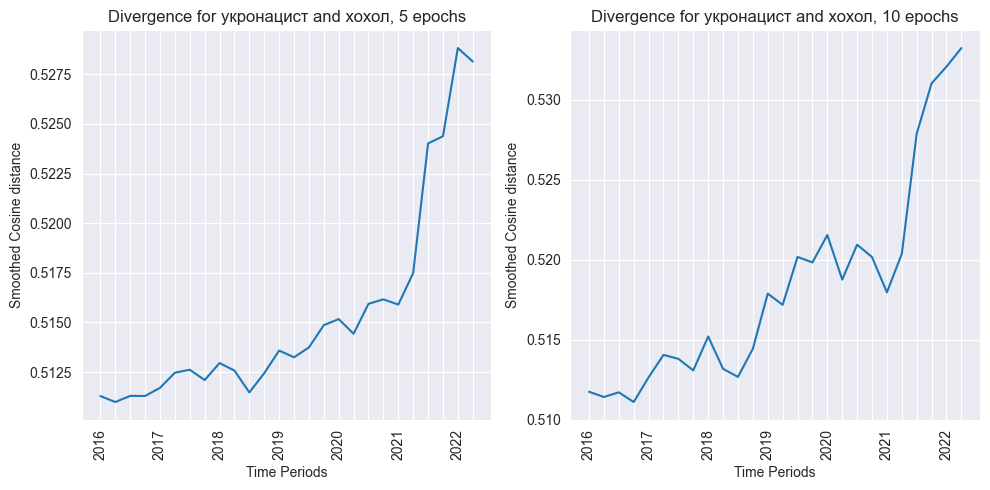

CPU times: user 2min 50s, sys: 29 s, total: 3min 19s
Wall time: 3min 33s


In [664]:
%%time
plot_all('укронацист', 'хохол')

['укронацистом', 'укронацист', 'укронацисту', 'укронацистов', 'укронациста', 'укронацисты', 'укронацисте', 'укронацистами', 'укронацистам', 'укронацистах']
********************************************************************************
['украинца', 'украинце', 'украинцев', 'украинцем', 'украинец', 'украинцами', 'украинцах', 'украинцу', 'украинцам', 'украинцы']
['укронацистом', 'укронацист', 'укронацисту', 'укронацистов', 'укронациста', 'укронацисты', 'укронацисте', 'укронацистами', 'укронацистам', 'укронацистах']
********************************************************************************
['украинца', 'украинце', 'украинцев', 'украинцем', 'украинец', 'украинцами', 'украинцах', 'украинцу', 'украинцам', 'украинцы']


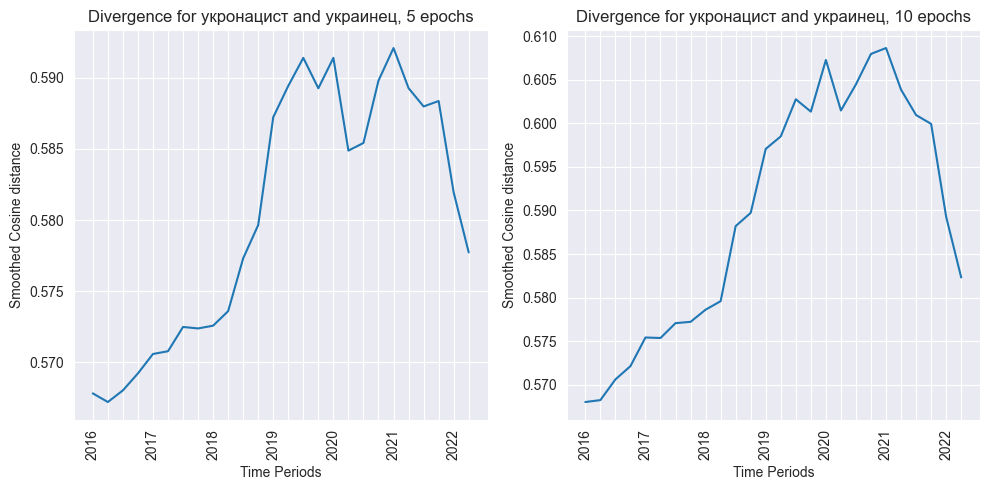

CPU times: user 2min 49s, sys: 27.9 s, total: 3min 17s
Wall time: 3min 31s


In [665]:
%%time
plot_all('укронацист', 'украинец')

['укронацистом', 'укронацист', 'укронацисту', 'укронацистов', 'укронациста', 'укронацисты', 'укронацисте', 'укронацистами', 'укронацистам', 'укронацистах']
********************************************************************************
['украм', 'укре', 'укра', 'украх', 'укром', 'украми', 'укров', 'укр', 'укру', 'укры']
['укронацистом', 'укронацист', 'укронацисту', 'укронацистов', 'укронациста', 'укронацисты', 'укронацисте', 'укронацистами', 'укронацистам', 'укронацистах']
********************************************************************************
['украм', 'укре', 'укра', 'украх', 'укром', 'украми', 'укров', 'укр', 'укру', 'укры']


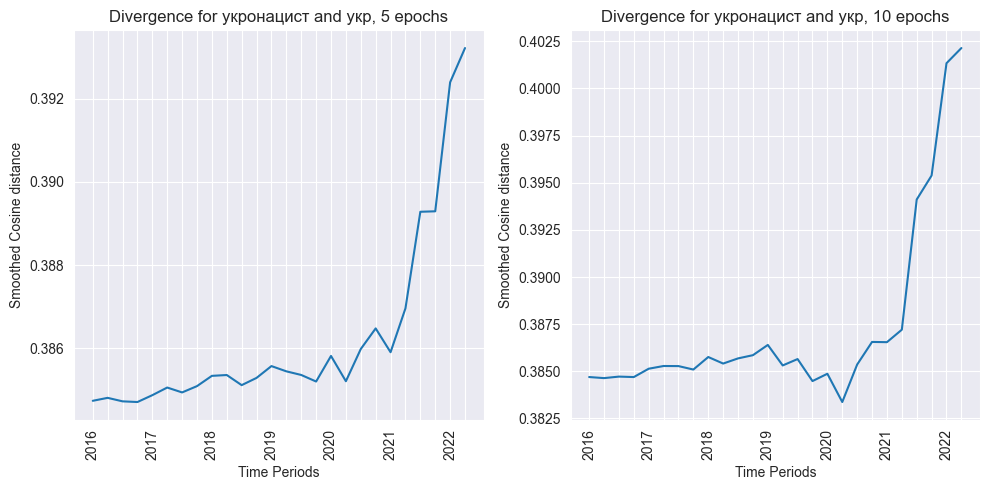

CPU times: user 2min 48s, sys: 27 s, total: 3min 15s
Wall time: 3min 27s


In [666]:
%%time
plot_all('укронацист', 'укр')

['украм', 'укре', 'укра', 'украх', 'укром', 'украми', 'укров', 'укр', 'укру', 'укры']
********************************************************************************
['украинца', 'украинце', 'украинцев', 'украинцем', 'украинец', 'украинцами', 'украинцах', 'украинцу', 'украинцам', 'украинцы']
['украм', 'укре', 'укра', 'украх', 'укром', 'украми', 'укров', 'укр', 'укру', 'укры']
********************************************************************************
['украинца', 'украинце', 'украинцев', 'украинцем', 'украинец', 'украинцами', 'украинцах', 'украинцу', 'украинцам', 'украинцы']


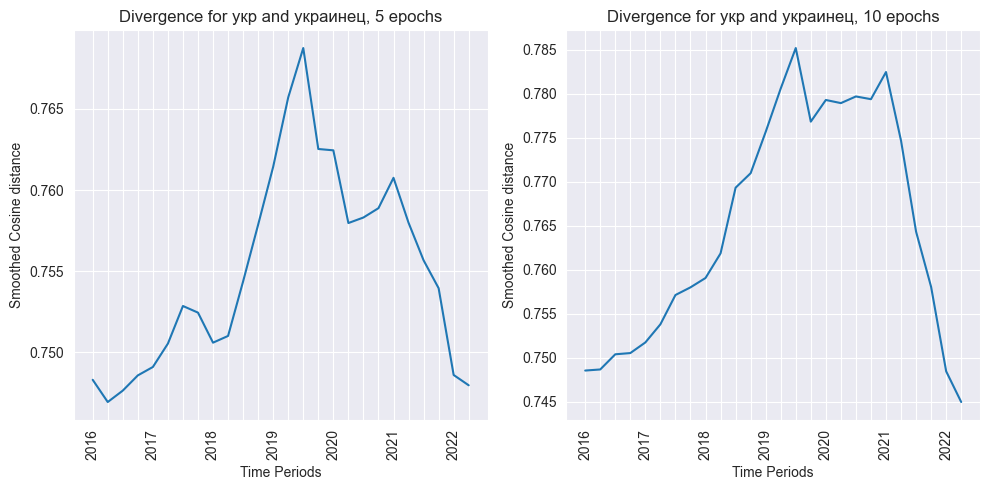

CPU times: user 2min 48s, sys: 28.7 s, total: 3min 17s
Wall time: 3min 32s


In [652]:
%%time
plot_all('укр', 'украинец')

['украм', 'укре', 'укра', 'украх', 'укром', 'украми', 'укров', 'укр', 'укру', 'укры']
********************************************************************************
['хохлом', 'хохлов', 'хохла', 'хохлу', 'хохлам', 'хохлы', 'хохлах', 'хохол', 'хохле', 'хохлами']
['украм', 'укре', 'укра', 'украх', 'укром', 'украми', 'укров', 'укр', 'укру', 'укры']
********************************************************************************
['хохлом', 'хохлов', 'хохла', 'хохлу', 'хохлам', 'хохлы', 'хохлах', 'хохол', 'хохле', 'хохлами']


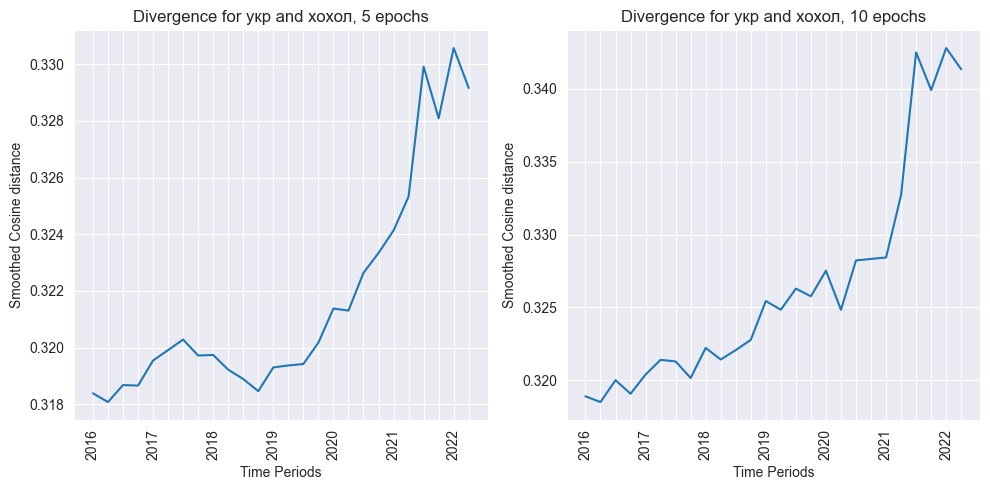

CPU times: user 2min 48s, sys: 28.8 s, total: 3min 17s
Wall time: 3min 31s


In [653]:
%%time
plot_all('укр', 'хохол')

['украинкою', 'украинки', 'украинку', 'украинкам', 'украинок', 'украинках', 'украинка', 'украинкой', 'украинками', 'украинке']
********************************************************************************
['хохлушках', 'хохлушки', 'хохлушке', 'хохлушка', 'хохлушкам', 'хохлушек', 'хохлушками', 'хохлушкою', 'хохлушку', 'хохлушкой']
['украинкою', 'украинки', 'украинку', 'украинкам', 'украинок', 'украинках', 'украинка', 'украинкой', 'украинками', 'украинке']
********************************************************************************
['хохлушках', 'хохлушки', 'хохлушке', 'хохлушка', 'хохлушкам', 'хохлушек', 'хохлушками', 'хохлушкою', 'хохлушку', 'хохлушкой']


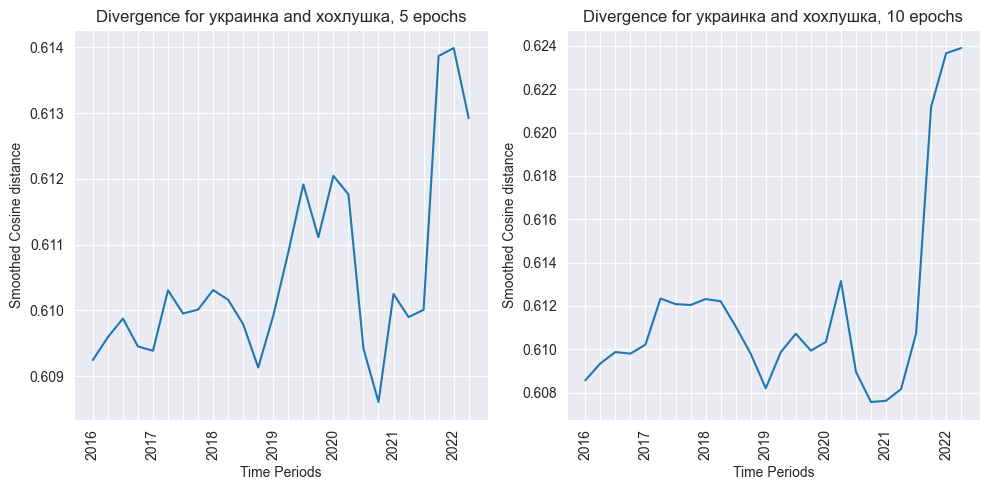

CPU times: user 2min 47s, sys: 28.9 s, total: 3min 16s
Wall time: 3min 30s


In [654]:
%%time
plot_all('украинка', 'хохлушка')

['укропами', 'укроп', 'укропы', 'укропам', 'укропах', 'укропе', 'укропу', 'укропа', 'укропом', 'укропов']
********************************************************************************
['хохлом', 'хохлов', 'хохла', 'хохлу', 'хохлам', 'хохлы', 'хохлах', 'хохол', 'хохле', 'хохлами']
['укропами', 'укроп', 'укропы', 'укропам', 'укропах', 'укропе', 'укропу', 'укропа', 'укропом', 'укропов']
********************************************************************************
['хохлом', 'хохлов', 'хохла', 'хохлу', 'хохлам', 'хохлы', 'хохлах', 'хохол', 'хохле', 'хохлами']


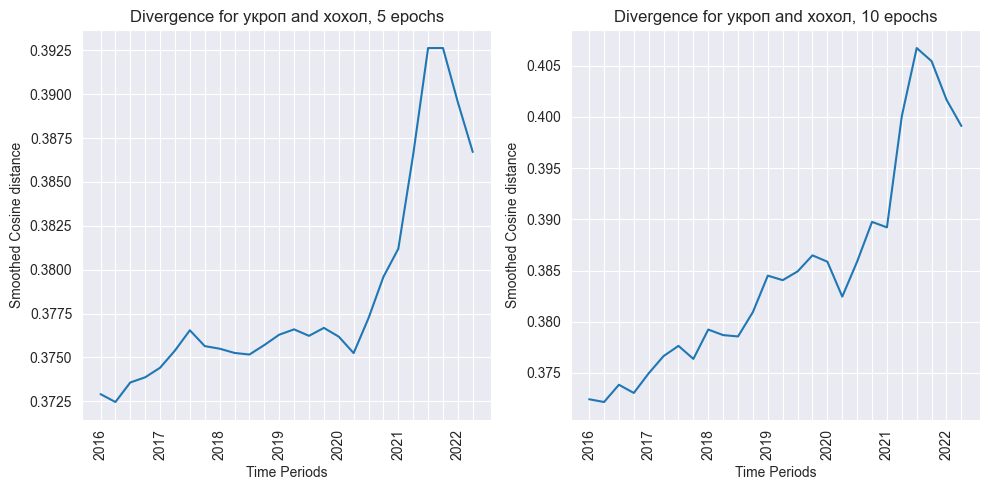

CPU times: user 2min 46s, sys: 28.4 s, total: 3min 15s
Wall time: 3min 29s


In [655]:
%%time
plot_all('укроп', 'хохол')

['укропами', 'укроп', 'укропы', 'укропам', 'укропах', 'укропе', 'укропу', 'укропа', 'укропом', 'укропов']
********************************************************************************
['украинца', 'украинце', 'украинцев', 'украинцем', 'украинец', 'украинцами', 'украинцах', 'украинцу', 'украинцам', 'украинцы']
['укропами', 'укроп', 'укропы', 'укропам', 'укропах', 'укропе', 'укропу', 'укропа', 'укропом', 'укропов']
********************************************************************************
['украинца', 'украинце', 'украинцев', 'украинцем', 'украинец', 'украинцами', 'украинцах', 'украинцу', 'украинцам', 'украинцы']


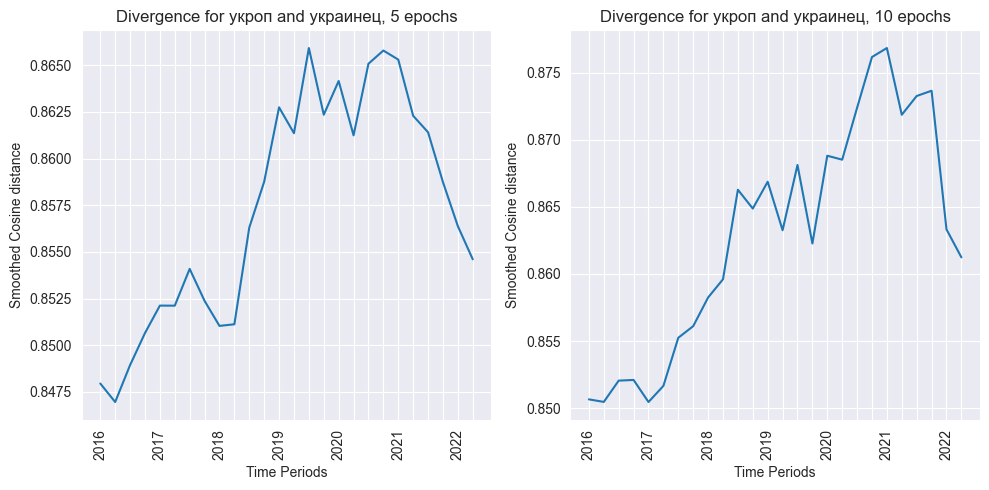

CPU times: user 2min 46s, sys: 28.8 s, total: 3min 15s
Wall time: 3min 29s


In [656]:
%%time
plot_all('укроп', 'украинец')

['укропами', 'укроп', 'укропы', 'укропам', 'укропах', 'укропе', 'укропу', 'укропа', 'укропом', 'укропов']
********************************************************************************
['укронацистом', 'укронацист', 'укронацисту', 'укронацистов', 'укронациста', 'укронацисты', 'укронацисте', 'укронацистами', 'укронацистам', 'укронацистах']
['укропами', 'укроп', 'укропы', 'укропам', 'укропах', 'укропе', 'укропу', 'укропа', 'укропом', 'укропов']
********************************************************************************
['укронацистом', 'укронацист', 'укронацисту', 'укронацистов', 'укронациста', 'укронацисты', 'укронацисте', 'укронацистами', 'укронацистам', 'укронацистах']


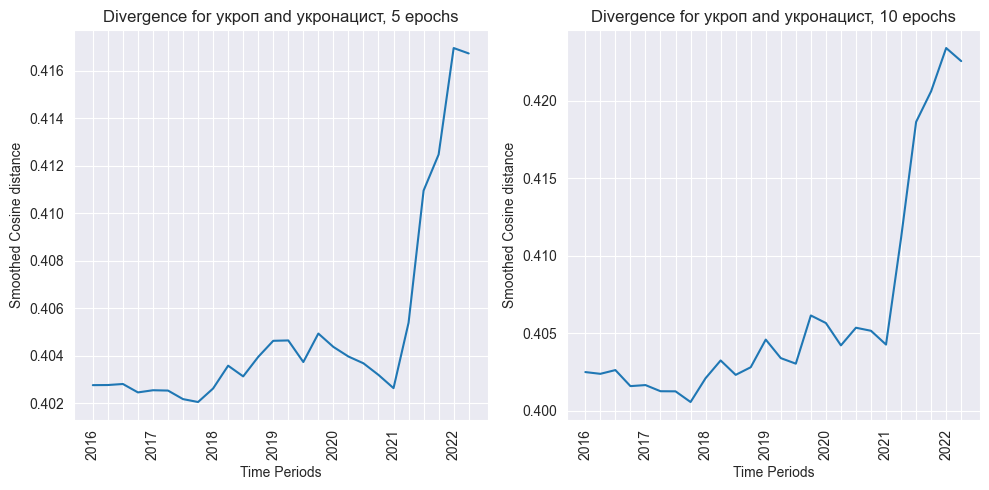

CPU times: user 2min 50s, sys: 28.9 s, total: 3min 19s
Wall time: 3min 33s


In [667]:
%%time
plot_all('укроп', 'укронацист')

# Pilot Study

In [132]:
import pandas as pd

In [134]:
%%time
df_full = pd.read_csv('/Users/katerynaburovova/PycharmProjects/dehumanization/data/merged_dataset/df_channels.csv')

<timed exec>:1: DtypeWarning: Columns (4,6,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 1min 15s, sys: 57.6 s, total: 2min 13s
Wall time: 4min 55s


In [187]:
#sample 0.01% of posts
df_sample_01_percent = df_full.sample(frac=0.0001, random_state=42)

In [188]:
len(df_sample_01_percent)

811

In [189]:
df_sample_01_percent_clean = df_sample_01_percent[['date', 'message']].copy()

In [190]:
df_sample_01_percent_clean.reset_index(inplace=True, drop=True)

In [191]:
df_sample_01_percent_clean

,date,message
0,2021-05-27 11:03:01+00:00,Катя «Твари по паре» талантливо изобразила Ана...
1,2020-06-29 11:35:01+00:00,Более 1 млн человек приняли участие в онлайн-г...
2,2022-11-16 15:35:00+00:00,Польский генерал Роман Полько предложил расшир...
3,2018-12-28 20:39:23+00:00,Погранслужба Украины опровергла заявление об о...
4,2021-01-29 09:33:31+00:00,Минтруд предложил 125 видов работ для прохожде...
...,...,...
806,2021-06-16 17:08:38+00:00,Путин уважает Байдена. К тому выводу пришли се...
807,2022-03-27 18:14:20+00:00,Московская Росгвардия к чему-то готовится. \nВ...
808,2022-03-04 17:42:39+00:00,NaN
809,2022-02-21 12:15:17+00:00,😕 Курс евро тоже полетел и достиг 89 рублей вп...


In [192]:
import pandas as pd
import numpy as np

df_sample_01_percent_clean['date'] = pd.to_datetime(df_sample_01_percent_clean['date'])

In [193]:
df_sample_01_percent_clean['post_id'] = np.arange(len(df_sample_01_percent_clean))

In [194]:
#predict the dehumanization

In [195]:
#calculate the standard deviation

In [196]:
df_sample_01_percent_clean

,date,message,post_id
0,2021-05-27 11:03:01+00:00,Катя «Твари по паре» талантливо изобразила Ана...,0
1,2020-06-29 11:35:01+00:00,Более 1 млн человек приняли участие в онлайн-г...,1
2,2022-11-16 15:35:00+00:00,Польский генерал Роман Полько предложил расшир...,2
3,2018-12-28 20:39:23+00:00,Погранслужба Украины опровергла заявление об о...,3
4,2021-01-29 09:33:31+00:00,Минтруд предложил 125 видов работ для прохожде...,4
...,...,...,...
806,2021-06-16 17:08:38+00:00,Путин уважает Байдена. К тому выводу пришли се...,806
807,2022-03-27 18:14:20+00:00,Московская Росгвардия к чему-то готовится. \nВ...,807
808,2022-03-04 17:42:39+00:00,NaN,808
809,2022-02-21 12:15:17+00:00,😕 Курс евро тоже полетел и достиг 89 рублей вп...,809


In [197]:
import tokenize_uk

df_sample_01_percent_clean['sentences'] = df_sample_01_percent_clean['message'].apply(tokenize_uk.tokenize_sents)

In [198]:
df_sample_01_percent_clean = df_sample_01_percent_clean.explode('sentences')

In [199]:
df_sample_01_percent_clean

,date,message,post_id,sentences
0,2021-05-27 11:03:01+00:00,Катя «Твари по паре» талантливо изобразила Ана...,0,Катя «Твари по паре» талантливо изобразила Ана...
0,2021-05-27 11:03:01+00:00,Катя «Твари по паре» талантливо изобразила Ана...,0,Получилось гораздо бодрее и интереснее оригина...
0,2021-05-27 11:03:01+00:00,Катя «Твари по паре» талантливо изобразила Ана...,0,В конце ещё гениальная пародию на «хит» Решето...
1,2020-06-29 11:35:01+00:00,Более 1 млн человек приняли участие в онлайн-г...,1,Более 1 млн человек приняли участие в онлайн-г...
2,2022-11-16 15:35:00+00:00,Польский генерал Роман Полько предложил расшир...,2,Польский генерал Роман Полько предложил расшир...
...,...,...,...,...
810,2022-01-20 09:55:38+00:00,"Лукашенко – о том, как он переболел омикроном:...",810,Если он вирус.
810,2022-01-20 09:55:38+00:00,"Лукашенко – о том, как он переболел омикроном:...",810,"Я подозреваю, что мы скатились уже к обычному ..."
810,2022-01-20 09:55:38+00:00,"Лукашенко – о том, как он переболел омикроном:...",810,Он не дает пневмоний.
810,2022-01-20 09:55:38+00:00,"Лукашенко – о том, как он переболел омикроном:...",810,"Я говорю это как человек, который сам второй р..."


In [200]:
pilot_sent_list = df_sample_01_percent_clean.sentences.to_list()

### pre-processing sentences for SpERT

In [201]:
import spacy

nlp = spacy.load("ru_core_news_md")

In [202]:
def tokenize_text(text):
    return [token.text for token in nlp(text)]

In [203]:
def get_SpERT_formatted_input(X):
    formatted_texts = []

    for text in X.sentences:
        tokens = tokenize_text(text)
        formatted_text = {"tokens": tokens}
        formatted_texts.append([formatted_text, tokens, text])

    return formatted_texts

In [204]:
%%time
Pilot_texts_formatted = get_SpERT_formatted_input(df_sample_01_percent_clean)

CPU times: user 19.5 s, sys: 283 ms, total: 19.8 s
Wall time: 20 s


In [205]:
pilot_list_of_dicts = []
for doc in Pilot_texts_formatted:
    pilot_list_of_dicts.append(doc[0])

In [207]:
import json

pilot_sample = '/Users/katerynaburovova/PycharmProjects/dehumanization/spert/data/datasets/test_datasets/pilot_sample.json'

with open(pilot_sample, 'w', encoding='utf-8') as f:
    json.dump(pilot_list_of_dicts, f, ensure_ascii=False, indent=4)

In [208]:
path_to_pilot_predictions = '/Users/katerynaburovova/PycharmProjects/dehumanization/spert/data/predictions_pilot.json'

In [209]:
with open(path_to_pilot_predictions, 'r') as file:
    data_pilot = json.load(file)

In [210]:
data_pilot

[{'tokens': ['Катя',
   '«',
   'Твари',
   'по',
   'паре',
   '»',
   'талантливо',
   'изобразила',
   'Анастасию',
   '(',
   'она',
   'же',
   'Амина',
   ',',
   'автор',
   'книги',
   '«',
   'Сегодня',
   'я',
   'христианка',
   ',',
   'а',
   'завтра',
   'мусульманка',
   '»',
   ')',
   'Решетову',
   '.'],
  'entities': [],
  'relations': []},
 {'tokens': ['Получилось',
   'гораздо',
   'бодрее',
   'и',
   'интереснее',
   'оригинального',
   '«',
   'Монолога',
   '»',
   '.'],
  'entities': [],
  'relations': []},
 {'tokens': ['В',
   'конце',
   'ещё',
   'гениальная',
   'пародию',
   'на',
   '«',
   'хит',
   '»',
   'Решетовой',
   '«',
   'Исчезни',
   '»',
   '.'],
  'entities': [],
  'relations': []},
 {'tokens': ['Более',
   '1',
   'млн',
   'человек',
   'приняли',
   'участие',
   'в',
   'онлайн',
   '-',
   'голосовании',
   'по',
   'поправкам',
   'к',
   'Конституции',
   'за',
   '29',
   'часов',
   'до',
   'его',
   'окончания',
   '—',
   'штаб'

In [211]:
df_pilot = pd.DataFrame(data_pilot)

In [219]:
df_pilot['post_id'] = np.arange(len(df_pilot))

In [220]:
df_pilot.iloc[522]

tokens       [Не, только, освобождать, ,, но, и, выжигать, ...
entities     [{'type': 'LOW_UH_LOW_NH', 'start': 10, 'end':...
relations                                                   []
post_id                                                    522
Name: 522, dtype: object

In [221]:
df_pilot_merged = df_sample_01_percent_clean.merge(df_pilot, on='post_id', how='inner')

In [222]:
len(df_pilot_merged)

2685

In [223]:
df_pilot_merged

,date,message,post_id,sentences,tokens,entities,relations
0,2021-05-27 11:03:01+00:00,Катя «Твари по паре» талантливо изобразила Ана...,0,Катя «Твари по паре» талантливо изобразила Ана...,"[Катя, «, Твари, по, паре, », талантливо, изоб...",[],[]
1,2021-05-27 11:03:01+00:00,Катя «Твари по паре» талантливо изобразила Ана...,0,Получилось гораздо бодрее и интереснее оригина...,"[Катя, «, Твари, по, паре, », талантливо, изоб...",[],[]
2,2021-05-27 11:03:01+00:00,Катя «Твари по паре» талантливо изобразила Ана...,0,В конце ещё гениальная пародию на «хит» Решето...,"[Катя, «, Твари, по, паре, », талантливо, изоб...",[],[]
3,2020-06-29 11:35:01+00:00,Более 1 млн человек приняли участие в онлайн-г...,1,Более 1 млн человек приняли участие в онлайн-г...,"[Получилось, гораздо, бодрее, и, интереснее, о...",[],[]
4,2022-11-16 15:35:00+00:00,Польский генерал Роман Полько предложил расшир...,2,Польский генерал Роман Полько предложил расшир...,"[В, конце, ещё, гениальная, пародию, на, «, хи...",[],[]
...,...,...,...,...,...,...,...
2680,2022-01-20 09:55:38+00:00,"Лукашенко – о том, как он переболел омикроном:...",810,Если он вирус.,"[▪, ️Зеленский, посетит, конференцию, по, безо...","[{'type': 'HIGH_UH_LOW_NH', 'start': 0, 'end':...",[]
2681,2022-01-20 09:55:38+00:00,"Лукашенко – о том, как он переболел омикроном:...",810,"Я подозреваю, что мы скатились уже к обычному ...","[▪, ️Зеленский, посетит, конференцию, по, безо...","[{'type': 'HIGH_UH_LOW_NH', 'start': 0, 'end':...",[]
2682,2022-01-20 09:55:38+00:00,"Лукашенко – о том, как он переболел омикроном:...",810,Он не дает пневмоний.,"[▪, ️Зеленский, посетит, конференцию, по, безо...","[{'type': 'HIGH_UH_LOW_NH', 'start': 0, 'end':...",[]
2683,2022-01-20 09:55:38+00:00,"Лукашенко – о том, как он переболел омикроном:...",810,"Я говорю это как человек, который сам второй р...","[▪, ️Зеленский, посетит, конференцию, по, безо...","[{'type': 'HIGH_UH_LOW_NH', 'start': 0, 'end':...",[]


In [225]:
df_pilot_merged.entities.value_counts()

[]                                                     2643
[{'type': 'LOW_UH_HIGH_NH', 'start': 7, 'end': 8}]       17
[{'type': 'HIGH_UH_LOW_NH', 'start': 0, 'end': 2}]       14
[{'type': 'LOW_UH_LOW_NH', 'start': 10, 'end': 11}]       6
[{'type': 'HIGH_UH_LOW_NH', 'start': 6, 'end': 7}]        2
[{'type': 'LOW_UH_LOW_NH', 'start': 7, 'end': 9}]         1
[{'type': 'HIGH_UH_LOW_NH', 'start': 0, 'end': 1}]        1
[{'type': 'HIGH_UH_LOW_NH', 'start': 1, 'end': 2}]        1
Name: entities, dtype: int64

In [237]:
entities_list = ['LOW_UH_HIGH_NH','LOW_UH_LOW_NH', 'HIGH_UH_LOW_NH', 'HIGH_UH_HIGH_NH']

In [238]:
for entity in entities_list:
    df_pilot_merged[entity] = df_pilot_merged['entities'].apply(lambda x: sum([1 for i in x if i['type'] == entity]))

In [239]:
df_pilot_merged

,date,message,post_id,sentences,tokens,entities,relations,LOW_UH_HIGH_NH,LOW_UH_LOW_NH,HIGH_UH_LOW_NH,HIGH_UH_HIGH_NH
0,2021-05-27 11:03:01+00:00,Катя «Твари по паре» талантливо изобразила Ана...,0,Катя «Твари по паре» талантливо изобразила Ана...,"[Катя, «, Твари, по, паре, », талантливо, изоб...",[],[],0,0,0,0
1,2021-05-27 11:03:01+00:00,Катя «Твари по паре» талантливо изобразила Ана...,0,Получилось гораздо бодрее и интереснее оригина...,"[Катя, «, Твари, по, паре, », талантливо, изоб...",[],[],0,0,0,0
2,2021-05-27 11:03:01+00:00,Катя «Твари по паре» талантливо изобразила Ана...,0,В конце ещё гениальная пародию на «хит» Решето...,"[Катя, «, Твари, по, паре, », талантливо, изоб...",[],[],0,0,0,0
3,2020-06-29 11:35:01+00:00,Более 1 млн человек приняли участие в онлайн-г...,1,Более 1 млн человек приняли участие в онлайн-г...,"[Получилось, гораздо, бодрее, и, интереснее, о...",[],[],0,0,0,0
4,2022-11-16 15:35:00+00:00,Польский генерал Роман Полько предложил расшир...,2,Польский генерал Роман Полько предложил расшир...,"[В, конце, ещё, гениальная, пародию, на, «, хи...",[],[],0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2680,2022-01-20 09:55:38+00:00,"Лукашенко – о том, как он переболел омикроном:...",810,Если он вирус.,"[▪, ️Зеленский, посетит, конференцию, по, безо...","[{'type': 'HIGH_UH_LOW_NH', 'start': 0, 'end':...",[],0,0,1,0
2681,2022-01-20 09:55:38+00:00,"Лукашенко – о том, как он переболел омикроном:...",810,"Я подозреваю, что мы скатились уже к обычному ...","[▪, ️Зеленский, посетит, конференцию, по, безо...","[{'type': 'HIGH_UH_LOW_NH', 'start': 0, 'end':...",[],0,0,1,0
2682,2022-01-20 09:55:38+00:00,"Лукашенко – о том, как он переболел омикроном:...",810,Он не дает пневмоний.,"[▪, ️Зеленский, посетит, конференцию, по, безо...","[{'type': 'HIGH_UH_LOW_NH', 'start': 0, 'end':...",[],0,0,1,0
2683,2022-01-20 09:55:38+00:00,"Лукашенко – о том, как он переболел омикроном:...",810,"Я говорю это как человек, который сам второй р...","[▪, ️Зеленский, посетит, конференцию, по, безо...","[{'type': 'HIGH_UH_LOW_NH', 'start': 0, 'end':...",[],0,0,1,0


In [240]:
df_pilot_merged.entities.value_counts()

[]                                                     2643
[{'type': 'LOW_UH_HIGH_NH', 'start': 7, 'end': 8}]       17
[{'type': 'HIGH_UH_LOW_NH', 'start': 0, 'end': 2}]       14
[{'type': 'LOW_UH_LOW_NH', 'start': 10, 'end': 11}]       6
[{'type': 'HIGH_UH_LOW_NH', 'start': 6, 'end': 7}]        2
[{'type': 'LOW_UH_LOW_NH', 'start': 7, 'end': 9}]         1
[{'type': 'HIGH_UH_LOW_NH', 'start': 0, 'end': 1}]        1
[{'type': 'HIGH_UH_LOW_NH', 'start': 1, 'end': 2}]        1
Name: entities, dtype: int64

In [241]:
df_pilot_merged.LOW_UH_HIGH_NH.value_counts()

0    2668
1      17
Name: LOW_UH_HIGH_NH, dtype: int64

In [243]:
average_entities_per_post = df_pilot_merged[entities_list].mean()

In [244]:
average_entities_per_post

LOW_UH_HIGH_NH     0.006331
LOW_UH_LOW_NH      0.002607
HIGH_UH_LOW_NH     0.006704
HIGH_UH_HIGH_NH    0.000000
dtype: float64

In [248]:
grouped_df = df_pilot_merged.groupby('post_id')[entities_list].mean().reset_index()

In [251]:
grouped_df.LOW_UH_LOW_NH

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
806    0.0
807    0.0
808    0.0
809    0.0
810    0.0
Name: LOW_UH_LOW_NH, Length: 811, dtype: float64

In [253]:
import numpy as np

sigma_LOW_UH_LOW_NH = np.std(grouped_df.LOW_UH_LOW_NH, ddof=1)
sigma_LOW_UH_LOW_NH

0.04962909114907327

In [254]:
sigma_LOW_UH_HIGH_NH = np.std(grouped_df.LOW_UH_HIGH_NH, ddof=1)
sigma_LOW_UH_HIGH_NH

0.03511474936103117

In [255]:
sigma_HIGH_UH_LOW_NH = np.std(grouped_df.HIGH_UH_LOW_NH, ddof=1)
sigma_HIGH_UH_LOW_NH

0.08574733453427218

In [258]:
import scipy.stats as stats
import math

confidence_level = 0.95  # for a 95% confidence interval
margin_of_error = 0.01  # for a 1% margin of error
z_score = abs(stats.norm.ppf((1 - confidence_level) / 2))
sample_size = ((z_score**2) * (sigma_HIGH_UH_LOW_NH**2)) / (margin_of_error**2)

print(f"The required sample size is {sample_size}")

The required sample size is 282.44730791056054


In [259]:
confidence_level = 0.95  # for a 95% confidence interval
margin_of_error = 0.01  # for a 1% margin of error
z_score = abs(stats.norm.ppf((1 - confidence_level) / 2))
sample_size = ((z_score**2) * (sigma_LOW_UH_HIGH_NH**2)) / (margin_of_error**2)

print(f"The required sample size is {sample_size}")

The required sample size is 47.36693983593248


In [260]:
confidence_level = 0.95  # for a 95% confidence interval
margin_of_error = 0.01  # for a 1% margin of error
z_score = abs(stats.norm.ppf((1 - confidence_level) / 2))
sample_size = ((z_score**2) * (sigma_LOW_UH_LOW_NH**2)) / (margin_of_error**2)

print(f"The required sample size is {sample_size}")

The required sample size is 94.6169242648627


### We will use 1000 posts per timestep to cover that.

1. get the timesteps

In [261]:
import os

slices_directory = '/Users/katerynaburovova/PycharmProjects/dehumanization/w2v_models/time_step_dataframes'
time_slices = []
file_names = os.listdir(slices_directory)
file_names = sorted(file_names, key=lambda name: int(name.split('_')[3]) if name.endswith('.csv') else float('inf'))

In [263]:
date_ranges = []
pattern = re.compile(r"\d{4}-\d{2}-\d{2}_to_\d{4}-\d{2}-\d{2}")

for filename in file_names:
    match = pattern.search(filename)
    if match:
        date_ranges.append(match.group())

print(date_ranges)

['2015-09-22_to_2015-12-22', '2015-12-23_to_2016-03-22', '2016-03-23_to_2016-06-22', '2016-06-22_to_2016-09-22', '2016-09-22_to_2016-12-22', '2016-12-22_to_2017-03-22', '2017-03-22_to_2017-06-22', '2017-06-22_to_2017-09-22', '2017-09-22_to_2017-12-22', '2017-12-22_to_2018-03-22', '2018-03-22_to_2018-06-22', '2018-06-22_to_2018-09-22', '2018-09-22_to_2018-12-22', '2018-12-22_to_2019-03-22', '2019-03-22_to_2019-06-22', '2019-06-22_to_2019-09-22', '2019-09-22_to_2019-12-22', '2019-12-22_to_2020-03-22', '2020-03-22_to_2020-06-22', '2020-06-22_to_2020-09-22', '2020-09-22_to_2020-12-22', '2020-12-22_to_2021-03-22', '2021-03-22_to_2021-06-22', '2021-06-22_to_2021-09-22', '2021-09-22_to_2021-12-22', '2021-12-22_to_2022-03-22', '2022-03-22_to_2022-06-22', '2022-06-22_to_2022-09-22', '2022-09-22_to_2022-12-22', '2022-12-22_to_2022-12-26']


2. divide the dataset into timesteps
3. sample 1000 posts from each timestep

In [264]:
%%time
df_full['date'] = pd.to_datetime(df_full['date'])

CPU times: user 2.79 s, sys: 18.5 s, total: 21.3 s
Wall time: 1min 26s


In [265]:
sampled_dataframes = []
date_ranges_tuples = [(start, end) for start, end in (range_.split('_to_') for range_ in date_ranges)]

In [266]:
%%time
for start, end in date_ranges_tuples:
    df_range = df_full[(df_full['date'] >= start) & (df_full['date'] <= end)]
    if len(df_range) >= 1000:
        df_sample = df_range.sample(1000, random_state=42)
    else:
        df_sample = df_range
    sampled_dataframes.append(df_sample)

CPU times: user 2.29 s, sys: 9.76 s, total: 12.1 s
Wall time: 28.2 s


In [267]:
df_sampled = pd.concat(sampled_dataframes)

In [274]:
df_sampled_final = df_sampled[['date', 'message', 'channel_name']].copy()

In [275]:
len(df_sampled_final)

30000

4. explode them into list

In [277]:
df_sampled_final['sentences'] = df_sampled_final['message'].apply(tokenize_uk.tokenize_sents)

In [279]:
df_sampled_final['post_id'] = np.arange(len(df_sampled_final))

In [280]:
df_sampled_final.head(20)

,date,message,channel_name,sentences,post_id
6791612,2015-12-18 14:01:44+00:00,Оперативники задержали предполагаемого убийцу ...,izvestia,[Оперативники задержали предполагаемого убийцу...,0
6792893,2015-12-01 12:55:12+00:00,"Мэр Киева Виталий Кличко принял присягу, но за...",izvestia,"[Мэр Киева Виталий Кличко принял присягу, но з...",1
6792651,2015-12-04 09:05:16+00:00,Аэропорты РФ потеряют 5 млрд руб. от закрытия ...,izvestia,[Аэропорты РФ потеряют 5 млрд руб. от закрытия...,2
6794395,2015-11-12 07:21:34+00:00,Рантье игровых залов пригрозили уголовным дело...,izvestia,[Рантье игровых залов пригрозили уголовным дел...,3
6793167,2015-11-27 09:15:16+00:00,В Крыму этой ночью заработал первый энергомост...,izvestia,[В Крыму этой ночью заработал первый энергомос...,4
6792796,2015-12-02 15:36:00+00:00,Школьники Азербайджана будут оштрафованы за пр...,izvestia,[Школьники Азербайджана будут оштрафованы за п...,5
6794689,2015-11-08 07:55:04+00:00,На Красной площади прошел марш в память о пара...,izvestia,[На Красной площади прошел марш в память о пар...,6
6792167,2015-12-10 16:45:08+00:00,Ходорковский объяснил суть своих призывов к ре...,izvestia,[Ходорковский объяснил суть своих призывов к р...,7
6792181,2015-12-10 14:16:28+00:00,#Бандера #Украина #авиация\n\nДмитрий Рогозин ...,izvestia,[#Бандера #Украина #авиация\n\nДмитрий Рогозин...,8
6795122,2015-10-24 09:25:48+00:00,"Цукерберг откроет школу, в которую будут прини...",izvestia,"[Цукерберг откроет школу, в которую будут прин...",9


In [352]:
df_sampled_sentence_level = df_sampled_final.explode('sentences')

In [357]:
len(df_sampled_sentence_level)

84853

5. format for SpERT

In [356]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [358]:
df_sampled_sentence_level['len_tokens'] = df_sampled_sentence_level['sentences'].apply(lambda x: len(tokenizer(x)['input_ids']))

Token indices sequence length is longer than the specified maximum sequence length for this model (604 > 512). Running this sequence through the model will result in indexing errors


In [365]:
print(f"Only {round(len(df_sampled_sentence_level[df_sampled_sentence_level['len_tokens']>=500])/len(df_sampled_sentence_level)*100,3)}% affected")

Only 0.403% affected


In [367]:
def crop_text(row):
    if row['len_tokens'] >= 500:
        return row['sentences'][:50]
    else:
        return row['sentences']

df_sampled_sentence_level['sentences'] = df_sampled_sentence_level.apply(crop_text, axis=1)

In [370]:
%%time
final_texts_formatted = get_SpERT_formatted_input(df_sampled_sentence_level)

CPU times: user 8min 58s, sys: 2.85 s, total: 9min 1s
Wall time: 9min 3s


In [371]:
final_list_of_dicts = []
for doc in final_texts_formatted:
    final_list_of_dicts.append(doc[0])

In [372]:
final_sample = '/Users/katerynaburovova/PycharmProjects/dehumanization/spert/data/datasets/test_datasets/final_sample.json'

with open(final_sample, 'w', encoding='utf-8') as f:
    json.dump(final_list_of_dicts, f, ensure_ascii=False, indent=4)

6. predict
7. read back and merge
8. process and plot

In [422]:
path_to_final_predictions = '/Users/katerynaburovova/PycharmProjects/dehumanization/spert/data/predictions_final.json'

In [423]:
with open(path_to_final_predictions, 'r') as file:
    data_final = json.load(file)

In [424]:
df_predicted_data = pd.DataFrame(data_final)
df_predicted_data['post_id'] = np.arange(len(df_predicted_data))

In [425]:
df_predicted_data_merged = df_sampled_sentence_level.merge(df_predicted_data, on='post_id', how='inner')

In [427]:
for entity in entities_list:
    df_predicted_data_merged[entity] = df_predicted_data_merged['entities'].apply(lambda x: sum([1 for i in x if i['type'] == entity]))

In [428]:
df_predicted_data_merged

,date,message,channel_name,sentences,post_id,len_tokens,len_tokens2,tokens,entities,relations,LOW_UH_HIGH_NH,LOW_UH_LOW_NH,HIGH_UH_LOW_NH,HIGH_UH_HIGH_NH
0,2015-12-18 14:01:44+00:00,Оперативники задержали предполагаемого убийцу ...,izvestia,Оперативники задержали предполагаемого убийцу ...,0,108,108,"[Оперативники, задержали, предполагаемого, уби...",[],[],0,0,0,0
1,2015-12-01 12:55:12+00:00,"Мэр Киева Виталий Кличко принял присягу, но за...",izvestia,"Мэр Киева Виталий Кличко принял присягу, но за...",1,113,113,"[Мэр, Киева, Виталий, Кличко, принял, присягу,...",[],[],0,0,0,0
2,2015-12-04 09:05:16+00:00,Аэропорты РФ потеряют 5 млрд руб. от закрытия ...,izvestia,Аэропорты РФ потеряют 5 млрд руб. от закрытия ...,2,109,109,"[Аэропорты, РФ, потеряют, 5, млрд, руб., от, з...",[],[],0,0,0,0
3,2015-11-12 07:21:34+00:00,Рантье игровых залов пригрозили уголовным дело...,izvestia,Рантье игровых залов пригрозили уголовным дело...,3,100,100,"[Рантье, игровых, залов, пригрозили, уголовным...",[],[],0,0,0,0
4,2015-11-27 09:15:16+00:00,В Крыму этой ночью заработал первый энергомост...,izvestia,В Крыму этой ночью заработал первый энергомост...,4,111,111,"[В, Крыму, этой, ночью, заработал, первый, эне...",[],[],0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84848,2022-12-22 06:58:17+00:00,Еще один комментарий Рогозина:\n\n«Это была ра...,truth_aggregator,Пострадали ещё несколько близких мне людей».,29997,41,41,"[Вот, вам, и, второй, за, сегодня, выпуск, руб...",[],[],0,0,0,0
84849,2022-12-25 08:23:11+00:00,"Ну что, меньше недели. Пора задать тот самый в...",ksbchk,"Ну что, меньше недели.",29998,21,21,"[Тут, @zhabaigaduka, дали, заднюю, мол, пост, ...",[],[],0,0,0,0
84850,2022-12-25 08:23:11+00:00,"Ну что, меньше недели. Пора задать тот самый в...",ksbchk,Пора задать тот самый вопрос.,29998,27,27,"[Тут, @zhabaigaduka, дали, заднюю, мол, пост, ...",[],[],0,0,0,0
84851,2022-12-25 08:23:11+00:00,"Ну что, меньше недели. Пора задать тот самый в...",ksbchk,Какие планы на Новый год?,29998,21,21,"[Тут, @zhabaigaduka, дали, заднюю, мол, пост, ...",[],[],0,0,0,0


In [430]:
df_predicted_data_merged.LOW_UH_LOW_NH.sum()

135

In [431]:
df_predicted_data_merged.HIGH_UH_LOW_NH.sum()

255

In [432]:
df_predicted_data_merged.LOW_UH_HIGH_NH.sum()

207

In [440]:
df_predicted_data_merged.HIGH_UH_HIGH_NH.sum()

0

In [445]:
df_predicted_data_merged.set_index('date', inplace=True)

,message,channel_name,sentences,post_id,len_tokens,len_tokens2,tokens,entities,relations,LOW_UH_HIGH_NH,LOW_UH_LOW_NH,HIGH_UH_LOW_NH,HIGH_UH_HIGH_NH
date,,,,,,,,,,,,,
2015-12-18 14:01:44+00:00,Оперативники задержали предполагаемого убийцу ...,izvestia,Оперативники задержали предполагаемого убийцу ...,0,108,108,"[Оперативники, задержали, предполагаемого, уби...",[],[],0,0,0,0
2015-12-01 12:55:12+00:00,"Мэр Киева Виталий Кличко принял присягу, но за...",izvestia,"Мэр Киева Виталий Кличко принял присягу, но за...",1,113,113,"[Мэр, Киева, Виталий, Кличко, принял, присягу,...",[],[],0,0,0,0
2015-12-04 09:05:16+00:00,Аэропорты РФ потеряют 5 млрд руб. от закрытия ...,izvestia,Аэропорты РФ потеряют 5 млрд руб. от закрытия ...,2,109,109,"[Аэропорты, РФ, потеряют, 5, млрд, руб., от, з...",[],[],0,0,0,0
2015-11-12 07:21:34+00:00,Рантье игровых залов пригрозили уголовным дело...,izvestia,Рантье игровых залов пригрозили уголовным дело...,3,100,100,"[Рантье, игровых, залов, пригрозили, уголовным...",[],[],0,0,0,0
2015-11-27 09:15:16+00:00,В Крыму этой ночью заработал первый энергомост...,izvestia,В Крыму этой ночью заработал первый энергомост...,4,111,111,"[В, Крыму, этой, ночью, заработал, первый, эне...",[],[],0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22 06:58:17+00:00,Еще один комментарий Рогозина:\n\n«Это была ра...,truth_aggregator,Пострадали ещё несколько близких мне людей».,29997,41,41,"[Вот, вам, и, второй, за, сегодня, выпуск, руб...",[],[],0,0,0,0
2022-12-25 08:23:11+00:00,"Ну что, меньше недели. Пора задать тот самый в...",ksbchk,"Ну что, меньше недели.",29998,21,21,"[Тут, @zhabaigaduka, дали, заднюю, мол, пост, ...",[],[],0,0,0,0
2022-12-25 08:23:11+00:00,"Ну что, меньше недели. Пора задать тот самый в...",ksbchk,Пора задать тот самый вопрос.,29998,27,27,"[Тут, @zhabaigaduka, дали, заднюю, мол, пост, ...",[],[],0,0,0,0


In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from matplotlib import dates
# from statsmodels.nonparametric.smoothers_lowess import lowess
#
# columns_to_plot = entities_list
# df_predicted_data_merged_ = df_predicted_data_merged[columns_to_plot].copy()
#
# df_monthly = df_predicted_data_merged_.resample('3M').sum()
#
# # Subset data up to 25th November 2022
# df_monthly = df_monthly[df_monthly.index <= '2022-11-25']
#
# # N = 5
# # df_monthly_rolling = df_monthly.rolling(window=N).mean()
#
# df_melted = df_monthly.reset_index().melt('date', var_name='a', value_name='b')
#
# plt.figure(figsize=(15, 8))
#
# for entity in entities_list:
#     entity_data = df_melted[df_melted['a'] == entity]
#     # Apply lowess smoother
#     smoothed = lowess(entity_data['b'], entity_data['date'])
#     plt.plot(smoothed[:, 0], smoothed[:, 1], label=entity)
#
# plt.scatter(data=df_melted, x="date", y="b", hue="a", s=10)
#
# ax = plt.gca()
# ax.xaxis.set_major_locator(dates.MonthLocator(interval=3))
# ax.xaxis.set_major_formatter(dates.DateFormatter('%B %Y'))
# plt.xticks(rotation=90)
#
# line_date = pd.to_datetime('2022-02-24')
# plt.axvline(line_date, color='r', linestyle='--', lw=2)
#
# offset_y = ax.get_ylim()[1] * 0.01
# plt.text(line_date, ax.get_ylim()[1] + offset_y, 'Start of 2022 Russian Invasion', color='red')
#
# plt.title('Temporal Dynamics of Dehumanization By Type', y=1.02)
#
# plt.legend(title='Dehumanization Type')
#
# plt.show()


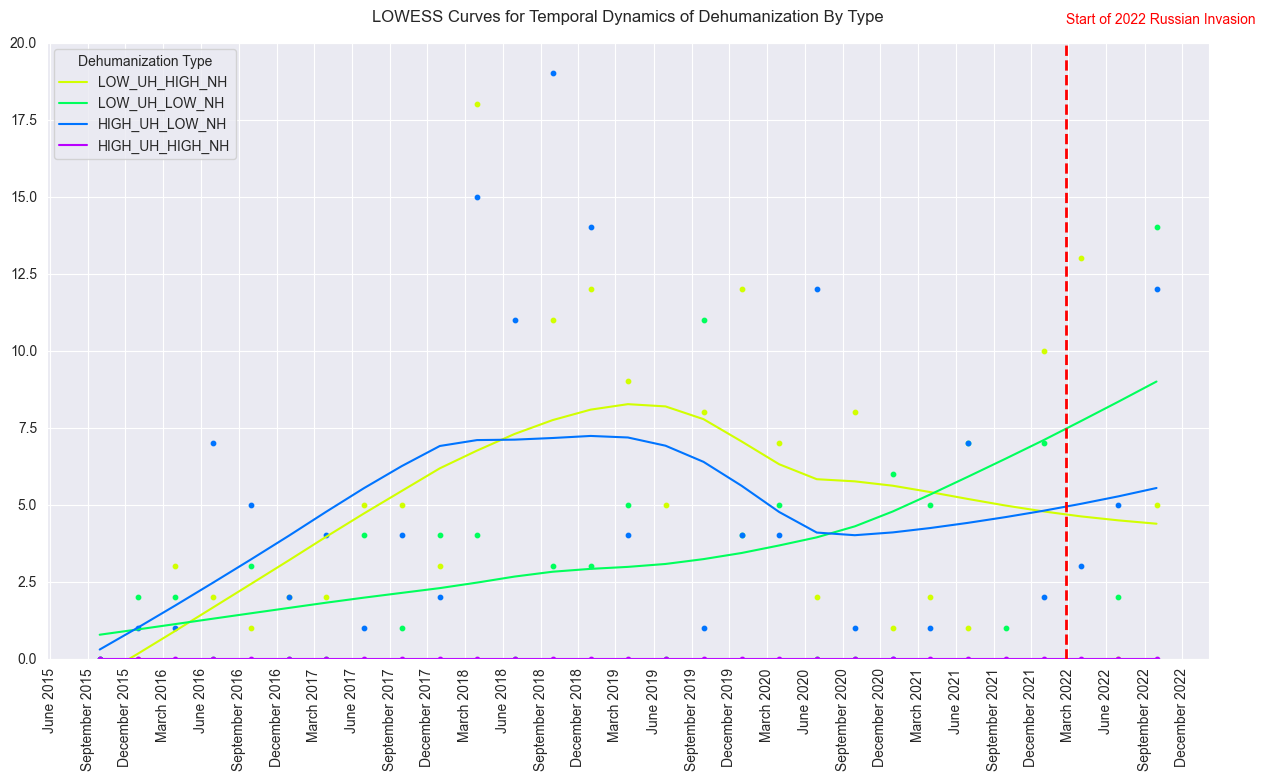

In [595]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np

columns_to_plot = entities_list
df_predicted_data_merged_ = df_predicted_data_merged[columns_to_plot].copy()

df_monthly = df_predicted_data_merged_.resample('3M').sum().copy()

# Subset data up to 25th November 2022
df_monthly = df_monthly[df_monthly.index <= '2022-11-25'].copy()

# N = 5
# df_monthly_rolling = df_monthly.rolling(window=N).mean()

df_melted = df_monthly.reset_index().melt('date', var_name='a', value_name='b').copy()

plt.figure(figsize=(15, 8))

colors = sns.color_palette("hsv", len(entities_list))

for i, entity in enumerate(entities_list):
    entity_data = df_melted[df_melted['a'] == entity].copy()

    # Convert date into numerical format for LOWESS
    entity_data['date_num'] = np.arange(len(entity_data))

    # Apply lowess smoother
    smoothed = lowess(entity_data['b'], entity_data['date_num'])

    # Plot lowess smoothed data
    plt.plot(entity_data['date'], smoothed[:, 1], color=colors[i], label=entity)

    # Scatter plot of original data
    plt.scatter(entity_data['date'], entity_data['b'], color=colors[i], s=10)

ax = plt.gca()
ax.xaxis.set_major_locator(dates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(dates.DateFormatter('%B %Y'))
plt.xticks(rotation=90)

line_date = pd.to_datetime('2022-02-24')
plt.axvline(line_date, color='r', linestyle='--', lw=2)

offset_y = ax.get_ylim()[1]*0.63
plt.text(line_date, ax.get_ylim()[1] - offset_y, 'Start of 2022 Russian Invasion', color='red')

plt.title('LOWESS Curves for Temporal Dynamics of Dehumanization By Type', y=1.02)

plt.legend(title='Dehumanization Type')
plt.ylim(0, 20)

plt.show()


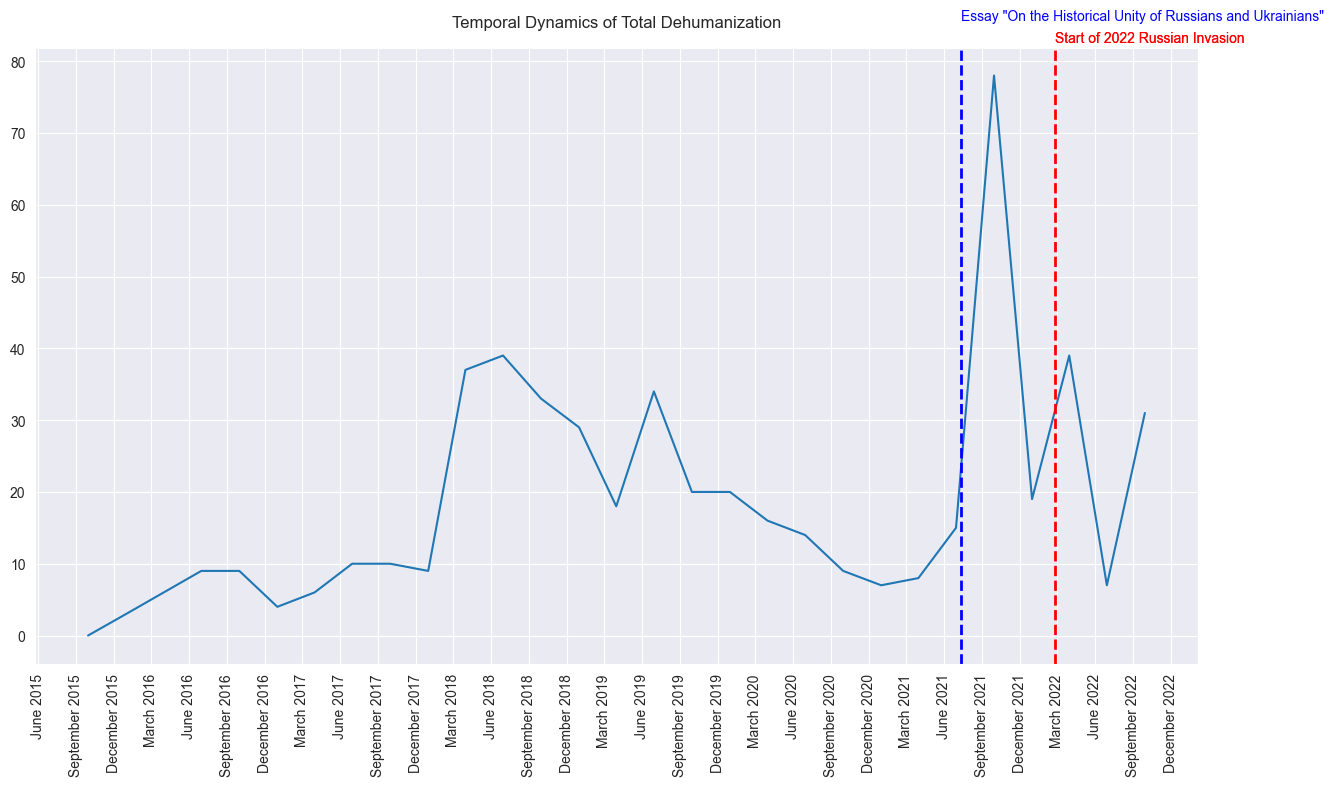

In [642]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates

columns_to_plot = ['LOW_UH_HIGH_NH', 'LOW_UH_LOW_NH', 'HIGH_UH_LOW_NH', 'HIGH_UH_HIGH_NH']
df_predicted_data_merged_ = df_predicted_data_merged[columns_to_plot].copy()

df_monthly = df_predicted_data_merged_.resample('3M').sum()

# Subset data up to 25th November 2022
df_monthly = df_monthly[df_monthly.index <= '2022-11-25']

N = 1
df_monthly_rolling = df_monthly.rolling(window=N).mean()

# Sum all the columns for each date
df_monthly_sum = df_monthly_rolling.sum(axis=1)

# Plotting the data
plt.figure(figsize=(15, 8))
sns.lineplot(x=df_monthly_sum.index, y=df_monthly_sum.values)
plt.title('Temporal Dynamics of Total Dehumanization', y=1.02)
plt.xlabel('')

# x-axis formatting
ax = plt.gca()
ax.xaxis.set_major_locator(dates.MonthLocator(interval=3))  # set the tick interval to 3 months
ax.xaxis.set_major_formatter(dates.DateFormatter('%B %Y'))  # set the date format to 'Month Year'
plt.xticks(rotation=90)

# Adding vertical line
line_date = pd.to_datetime('2022-02-24')
plt.axvline(line_date, color='r', linestyle='--', lw=2)
#
line_date2 = pd.to_datetime('2021-07-12')
plt.axvline(line_date2, color='b', linestyle='--', lw=2)

offset_y = ax.get_ylim()[1] * 0.01
plt.text(line_date, ax.get_ylim()[1] + offset_y, 'Start of 2022 Russian Invasion', color='red')
plt.text(line_date2, ax.get_ylim()[1]+ offset_y+3, 'Essay "On the Historical Unity of Russians and Ukrainians"', color='blue')

# Adding text label
offset_y = ax.get_ylim()[1] * 0.01
plt.text(line_date, ax.get_ylim()[1] + offset_y, 'Start of 2022 Russian Invasion', color='red')

plt.show()


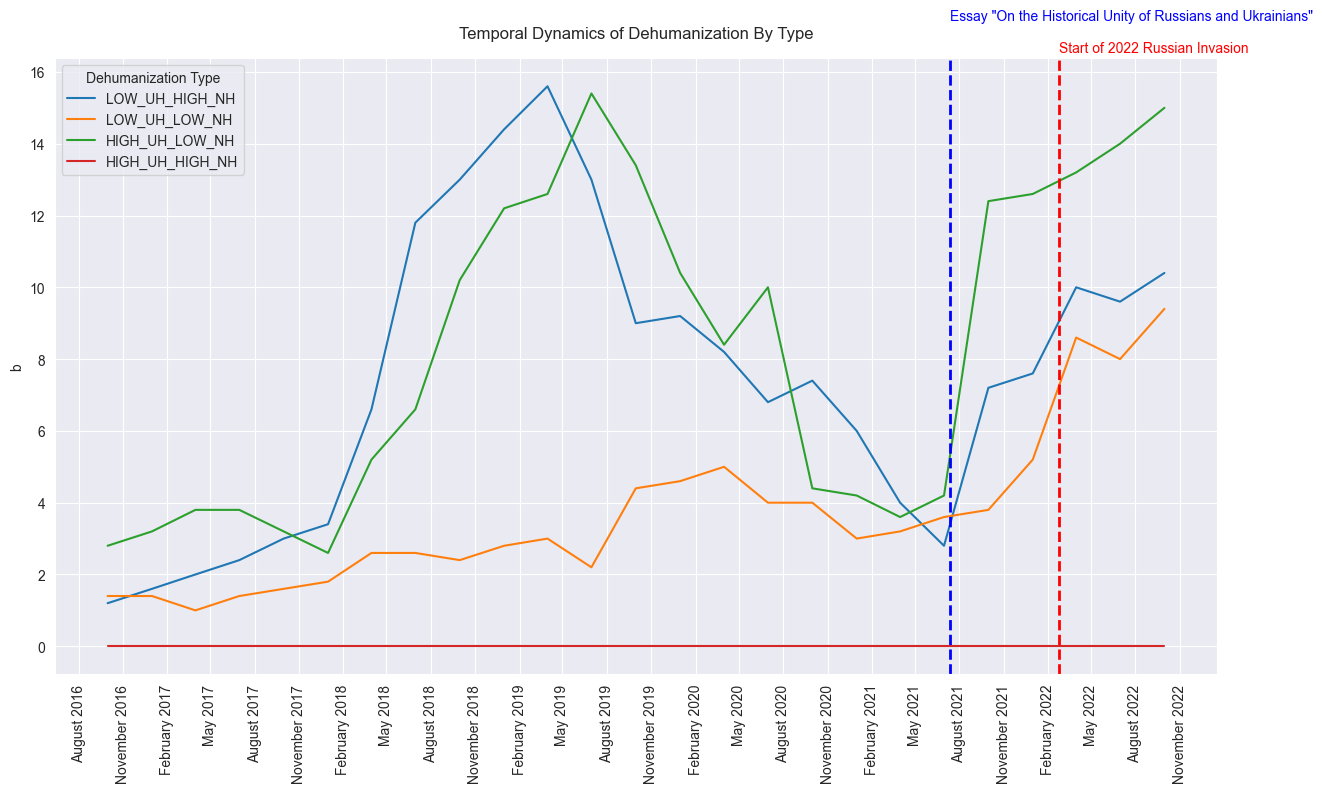

In [659]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import dates

columns_to_plot = entities_list
df_predicted_data_merged_ = df_predicted_data_merged[columns_to_plot].copy()

df_monthly = df_predicted_data_merged_.resample('3M').sum()

# Subset data up to 25th November 2022
df_monthly = df_monthly[df_monthly.index <= '2022-11-25']

N = 5
df_monthly_rolling = df_monthly.rolling(window=N).mean()

df_melted = df_monthly_rolling.reset_index().melt('date', var_name='a', value_name='b')

plt.figure(figsize=(15, 8))
plot = sns.lineplot(data=df_melted, x="date", y="b", hue="a")
plot.set_xlabel('')

ax = plt.gca()
ax.xaxis.set_major_locator(dates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(dates.DateFormatter('%B %Y'))
plt.xticks(rotation=90)

line_date = pd.to_datetime('2022-02-24')
plt.axvline(line_date, color='r', linestyle='--', lw=2)
#
line_date2 = pd.to_datetime('2021-07-12')
plt.axvline(line_date2, color='b', linestyle='--', lw=2)

offset_y = ax.get_ylim()[1] * 0.01
plt.text(line_date, ax.get_ylim()[1] + offset_y, 'Start of 2022 Russian Invasion', color='red')
plt.text(line_date2, ax.get_ylim()[1]+ offset_y+0.9, 'Essay "On the Historical Unity of Russians and Ukrainians"', color='blue')


plt.title('Temporal Dynamics of Dehumanization By Type', y=1.02)

leg = ax.legend()
leg.set_title('Dehumanization Type')

plt.show()

 ## Concept vector distance

In [524]:
import os
import glob

def read_all_files(directory):
    files = glob.glob(os.path.join(directory, '*.txt'))
    lists_dict = {}
    for file in files:
        with open(file, 'r') as f:
            content = f.read()
            list = content.split(',')
            list = [item.strip(' ') for item in list]
            filename = os.path.splitext(os.path.basename(file))[0]  # Extract filename without extension
            lists_dict[filename] = list
    return lists_dict

In [525]:
lists_dict = read_all_files('/Users/katerynaburovova/PycharmProjects/dehumanization/lexicons/NRC_VAD_ru')

In [528]:
lists_dict.keys()

dict_keys(['joyrus', 'fearrus', 'positiverus', 'negativerus', 'sadnessrus', 'disgustrus', 'surpriserus', 'angerrus', 'anticipationrus', 'trustrus'])

In [621]:
from gensim.models import Word2Vec
from matplotlib.ticker import MaxNLocator


def plot_denotation_divergence_concept_vec(ax, term_one, term_two, models_path, epochs, concept, window):
    terms_one = get_word_forms(term_one)
    terms_two = get_word_forms(term_two)
    print(terms_one)
    print('*'*80)
    print(terms_two[:20])
    distance_list = []
    time_periods = []

    model_files = sorted(os.listdir(models_path), key=lambda x: extract_time_period(x)[0] if x.endswith('.model') else '')

    for model_name in model_files:
        if not model_name.endswith('.model'):
            continue

        start_date, end_date = extract_time_period(model_name)
        if not start_date or not end_date:
            continue

        model_path = os.path.join(models_path, model_name)
        model = Word2Vec.load(model_path)
        model = zerocenter_normalize(model)

        centroid1 = get_centroid(terms_one, model)
        centroid2 = get_centroid(terms_two, model)

        if centroid1 is None or centroid2 is None:
            continue

        distance = calculate_distance(centroid1, centroid2)
        distance_list.append(distance)
        time_periods.append(f'{start_date[:4]}')

    weights = np.repeat(1.0, window_size) / window_size
    smoothed_distances = np.convolve(distance_list, weights, 'valid')

    ax.plot(smoothed_distances)

    xticks_labels = [year if i%4==0 else '' for i, year in enumerate(time_periods[window_size-1:])]

    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xticks(range(len(smoothed_distances)))
    ax.set_xticklabels(xticks_labels, rotation=90)
    ax.set_xlabel('Time Periods')
    ax.set_ylabel('Smoothed Cosine distance')
    ax.set_title('Distance between {} and {}, {} epochs'.format(term_one, concept, epochs))


def plot_all_concept(term_one, term_two, concept, window = 3):

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    plot_denotation_divergence_concept_vec(axs[0], term_one, term_two, models_path_few_epoch, 5, concept, window)
    plot_denotation_divergence_concept_vec(axs[1], term_one, term_two, models_path, 10, concept, window)

    plt.tight_layout()
    plt.show()

['украинца', 'украинце', 'украинцев', 'украинцем', 'украинец', 'украинцами', 'украинцах', 'украинцу', 'украинцам', 'украинцы']
********************************************************************************
['', 'шантажированные', 'правящую', 'наиопаснейшими', 'дискриминация', 'отсутствуйте', 'похоронившее', 'кораблекрушеньях', 'разрушителе', 'наказанная', 'грубость', 'загадочное', 'хлопаемые', 'врагом', 'наиподлейшего', 'депортируемых', 'загадочна', 'бронируемый', 'убежищ', 'причинять']
['украинца', 'украинце', 'украинцев', 'украинцем', 'украинец', 'украинцами', 'украинцах', 'украинцу', 'украинцам', 'украинцы']
********************************************************************************
['', 'шантажированные', 'правящую', 'наиопаснейшими', 'дискриминация', 'отсутствуйте', 'похоронившее', 'кораблекрушеньях', 'разрушителе', 'наказанная', 'грубость', 'загадочное', 'хлопаемые', 'врагом', 'наиподлейшего', 'депортируемых', 'загадочна', 'бронируемый', 'убежищ', 'причинять']


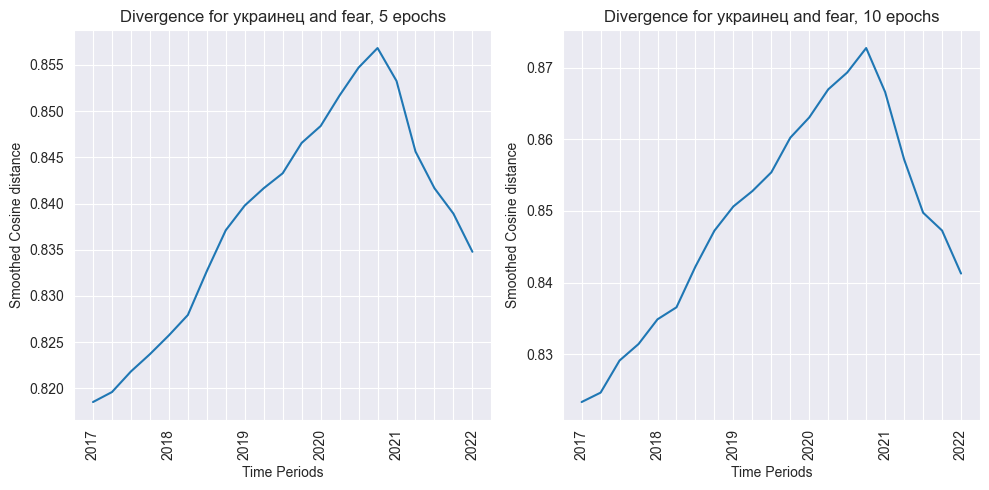

CPU times: user 2min 53s, sys: 31.2 s, total: 3min 24s
Wall time: 3min 41s


In [620]:
%%time
plot_all_concept('украинец', lists_dict['fearrus'], 'fear')

['украинца', 'украинце', 'украинцев', 'украинцем', 'украинец', 'украинцами', 'украинцах', 'украинцу', 'украинцам', 'украинцы']
********************************************************************************
['', 'дискриминация', 'тошноты', 'ворчала', 'понепростительнее', 'понепокорнее', 'извратит', 'наказанная', 'непристойному', 'врагом', 'дефектное', 'наиподлейшего', 'падонка', 'раздувшем', 'волосатейшем', 'флигель', 'термиту', 'шумов', 'бессмысленнейших', 'желатине']
['украинца', 'украинце', 'украинцев', 'украинцем', 'украинец', 'украинцами', 'украинцах', 'украинцу', 'украинцам', 'украинцы']
********************************************************************************
['', 'дискриминация', 'тошноты', 'ворчала', 'понепростительнее', 'понепокорнее', 'извратит', 'наказанная', 'непристойному', 'врагом', 'дефектное', 'наиподлейшего', 'падонка', 'раздувшем', 'волосатейшем', 'флигель', 'термиту', 'шумов', 'бессмысленнейших', 'желатине']


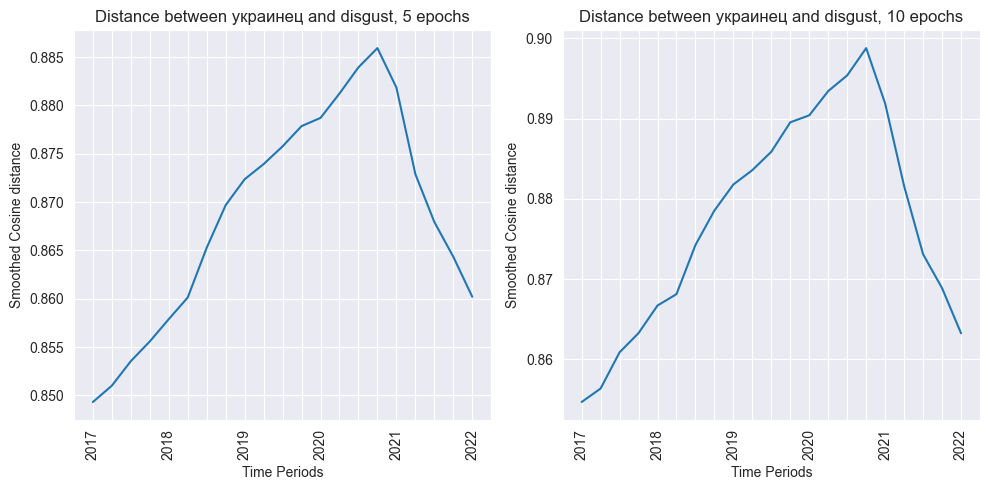

CPU times: user 2min 53s, sys: 33.1 s, total: 3min 26s
Wall time: 3min 46s


In [622]:
%%time
plot_all_concept('украинец', lists_dict['disgustrus'], 'disgust')

['украинца', 'украинце', 'украинцев', 'украинцем', 'украинец', 'украинцами', 'украинцах', 'украинцу', 'украинцам', 'украинцы']
********************************************************************************
['', 'шантажированные', 'дискриминация', 'свалках', 'ворчала', 'понепростительнее', 'понепокорнее', 'разрушителе', 'наказанная', 'грубость', 'хлопаемые', 'врагом', 'наиподлейшего', 'отменяем', 'причинять', 'защиту', 'шумов', 'бессмысленнейших', 'гашенными', 'хищно']
['украинца', 'украинце', 'украинцев', 'украинцем', 'украинец', 'украинцами', 'украинцах', 'украинцу', 'украинцам', 'украинцы']
********************************************************************************
['', 'шантажированные', 'дискриминация', 'свалках', 'ворчала', 'понепростительнее', 'понепокорнее', 'разрушителе', 'наказанная', 'грубость', 'хлопаемые', 'врагом', 'наиподлейшего', 'отменяем', 'причинять', 'защиту', 'шумов', 'бессмысленнейших', 'гашенными', 'хищно']


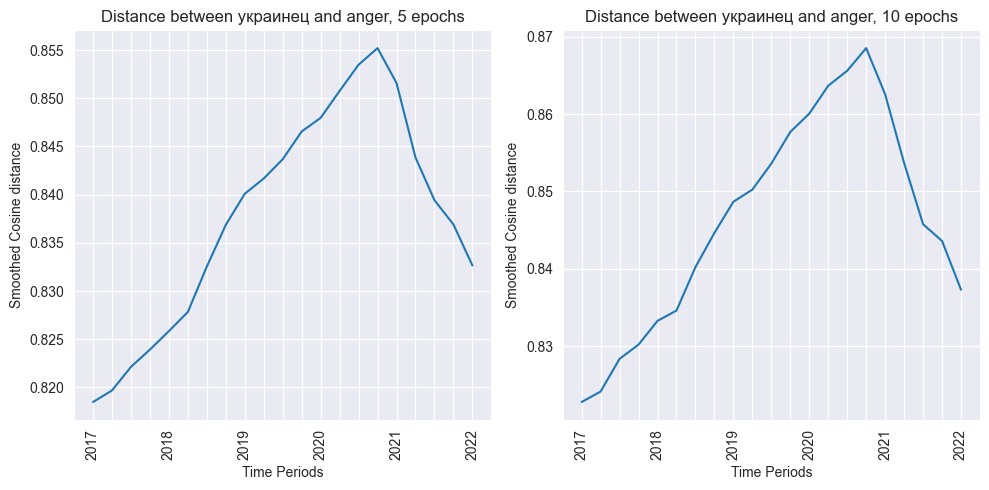

CPU times: user 2min 56s, sys: 37.8 s, total: 3min 34s
Wall time: 4min 1s


In [624]:
%%time
plot_all_concept('украинец', lists_dict['angerrus'], 'anger')

['украинца', 'украинце', 'украинцев', 'украинцем', 'украинец', 'украинцами', 'украинцах', 'украинцу', 'украинцам', 'украинцы']
********************************************************************************
['', 'наиопаснейшими', 'дискриминация', 'свалках', 'отсутствуйте', 'похоронившее', 'кораблекрушеньях', 'понепростительнее', 'наказанная', 'понеспособней', 'вылет изшая', 'депортируемых', 'потерянное', 'апатичным', 'причинять', 'бессмысленнейших', 'спойлерами', 'хищно', 'невнимательные', 'скорбишь']
['украинца', 'украинце', 'украинцев', 'украинцем', 'украинец', 'украинцами', 'украинцах', 'украинцу', 'украинцам', 'украинцы']
********************************************************************************
['', 'наиопаснейшими', 'дискриминация', 'свалках', 'отсутствуйте', 'похоронившее', 'кораблекрушеньях', 'понепростительнее', 'наказанная', 'понеспособней', 'вылет изшая', 'депортируемых', 'потерянное', 'апатичным', 'причинять', 'бессмысленнейших', 'спойлерами', 'хищно', 'невнимательны

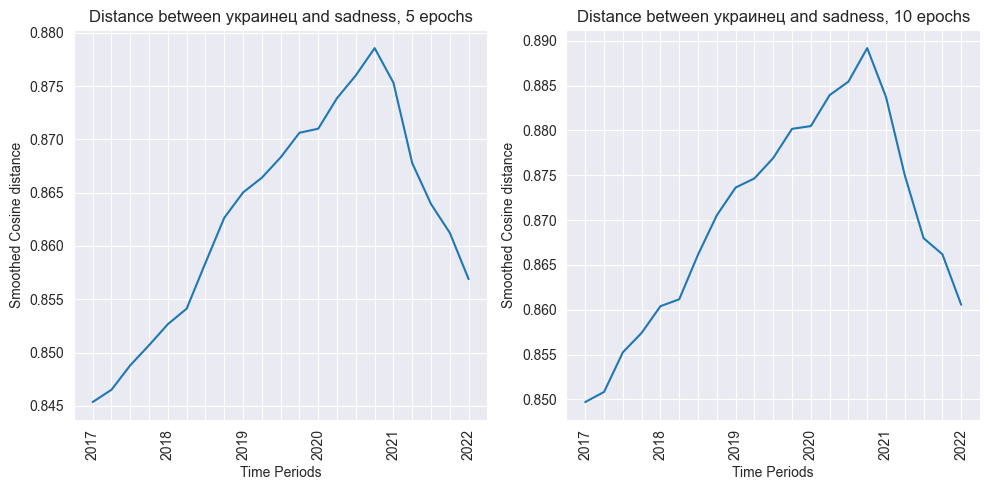

CPU times: user 2min 57s, sys: 33.7 s, total: 3min 31s
Wall time: 3min 53s


In [625]:
%%time
plot_all_concept('украинец', lists_dict['sadnessrus'], 'sadness')

['украинца', 'украинце', 'украинцев', 'украинцем', 'украинец', 'украинцами', 'украинцах', 'украинцу', 'украинцам', 'украинцы']
********************************************************************************
['', 'правящую', 'разъяснёнными', 'почтениях', 'посмеиваются', 'поручениях', 'обнимающей', 'составляем', 'приходом', 'сплочена', 'выздоровление', 'оживим', 'дополняема', 'полулежавшем', 'наполняющей', 'наклоняешь', 'защиту', 'сторожащему', 'умнейшем', 'моногамиях']
['украинца', 'украинце', 'украинцев', 'украинцем', 'украинец', 'украинцами', 'украинцах', 'украинцу', 'украинцам', 'украинцы']
********************************************************************************
['', 'правящую', 'разъяснёнными', 'почтениях', 'посмеиваются', 'поручениях', 'обнимающей', 'составляем', 'приходом', 'сплочена', 'выздоровление', 'оживим', 'дополняема', 'полулежавшем', 'наполняющей', 'наклоняешь', 'защиту', 'сторожащему', 'умнейшем', 'моногамиях']


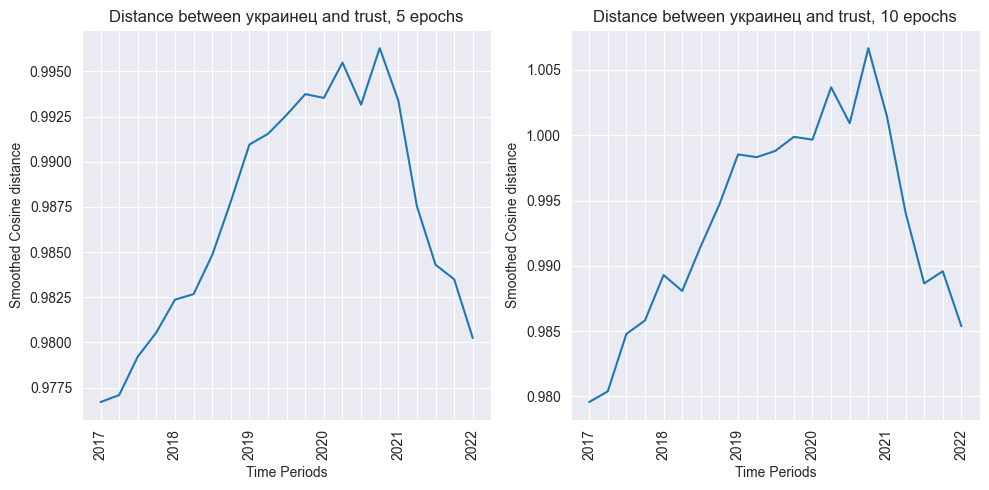

CPU times: user 2min 55s, sys: 30.4 s, total: 3min 25s
Wall time: 3min 41s


In [626]:
%%time
plot_all_concept('украинец', lists_dict['trustrus'], 'trust')

['хохлом', 'хохлов', 'хохла', 'хохлу', 'хохлам', 'хохлы', 'хохлах', 'хохол', 'хохле', 'хохлами']
********************************************************************************
['', 'дискриминация', 'тошноты', 'ворчала', 'понепростительнее', 'понепокорнее', 'извратит', 'наказанная', 'непристойному', 'врагом', 'дефектное', 'наиподлейшего', 'падонка', 'раздувшем', 'волосатейшем', 'флигель', 'термиту', 'шумов', 'бессмысленнейших', 'желатине']
['хохлом', 'хохлов', 'хохла', 'хохлу', 'хохлам', 'хохлы', 'хохлах', 'хохол', 'хохле', 'хохлами']
********************************************************************************
['', 'дискриминация', 'тошноты', 'ворчала', 'понепростительнее', 'понепокорнее', 'извратит', 'наказанная', 'непристойному', 'врагом', 'дефектное', 'наиподлейшего', 'падонка', 'раздувшем', 'волосатейшем', 'флигель', 'термиту', 'шумов', 'бессмысленнейших', 'желатине']


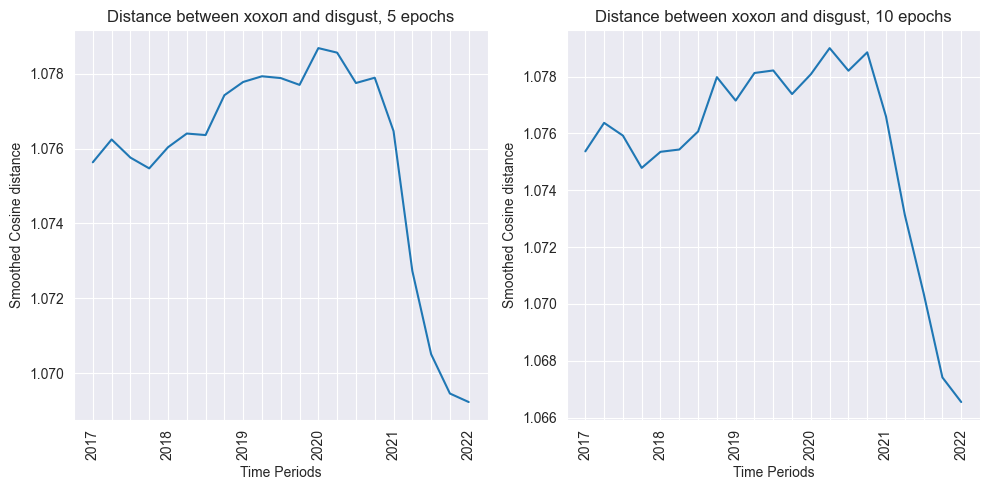

CPU times: user 2min 50s, sys: 30.1 s, total: 3min 20s
Wall time: 3min 37s


In [623]:
%%time
plot_all_concept('хохол', lists_dict['disgustrus'], 'disgust')

['хохлом', 'хохлов', 'хохла', 'хохлу', 'хохлам', 'хохлы', 'хохлах', 'хохол', 'хохле', 'хохлами']
********************************************************************************
['', 'шантажированные', 'правящую', 'наиопаснейшими', 'дискриминация', 'отсутствуйте', 'похоронившее', 'кораблекрушеньях', 'разрушителе', 'наказанная', 'грубость', 'загадочное', 'хлопаемые', 'врагом', 'наиподлейшего', 'депортируемых', 'загадочна', 'бронируемый', 'убежищ', 'причинять']
['хохлом', 'хохлов', 'хохла', 'хохлу', 'хохлам', 'хохлы', 'хохлах', 'хохол', 'хохле', 'хохлами']
********************************************************************************
['', 'шантажированные', 'правящую', 'наиопаснейшими', 'дискриминация', 'отсутствуйте', 'похоронившее', 'кораблекрушеньях', 'разрушителе', 'наказанная', 'грубость', 'загадочное', 'хлопаемые', 'врагом', 'наиподлейшего', 'депортируемых', 'загадочна', 'бронируемый', 'убежищ', 'причинять']


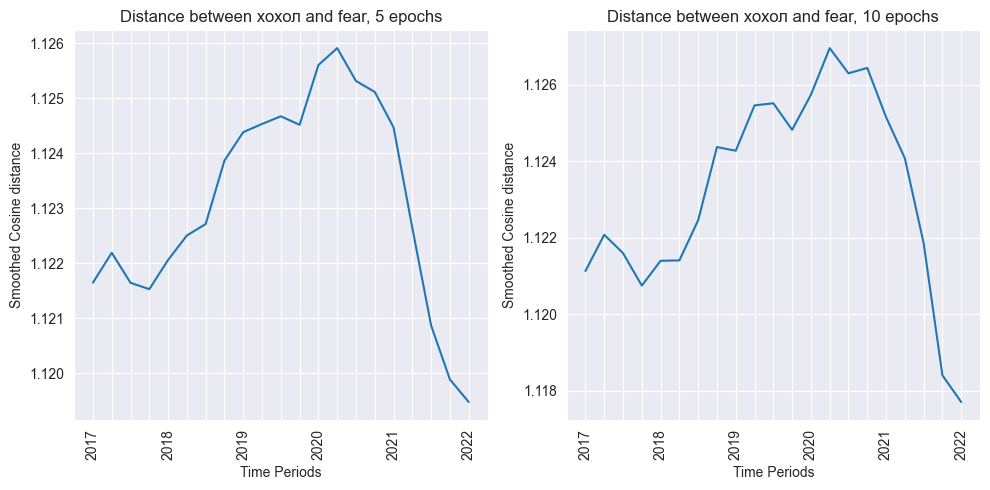

CPU times: user 2min 53s, sys: 32.9 s, total: 3min 26s
Wall time: 3min 46s


In [627]:
%%time
plot_all_concept('хохол', lists_dict['fearrus'], 'fear')

['хохлом', 'хохлов', 'хохла', 'хохлу', 'хохлам', 'хохлы', 'хохлах', 'хохол', 'хохле', 'хохлами']
********************************************************************************
['', 'наиопаснейшими', 'дискриминация', 'свалках', 'отсутствуйте', 'похоронившее', 'кораблекрушеньях', 'понепростительнее', 'наказанная', 'понеспособней', 'вылет изшая', 'депортируемых', 'потерянное', 'апатичным', 'причинять', 'бессмысленнейших', 'спойлерами', 'хищно', 'невнимательные', 'скорбишь']
['хохлом', 'хохлов', 'хохла', 'хохлу', 'хохлам', 'хохлы', 'хохлах', 'хохол', 'хохле', 'хохлами']
********************************************************************************
['', 'наиопаснейшими', 'дискриминация', 'свалках', 'отсутствуйте', 'похоронившее', 'кораблекрушеньях', 'понепростительнее', 'наказанная', 'понеспособней', 'вылет изшая', 'депортируемых', 'потерянное', 'апатичным', 'причинять', 'бессмысленнейших', 'спойлерами', 'хищно', 'невнимательные', 'скорбишь']


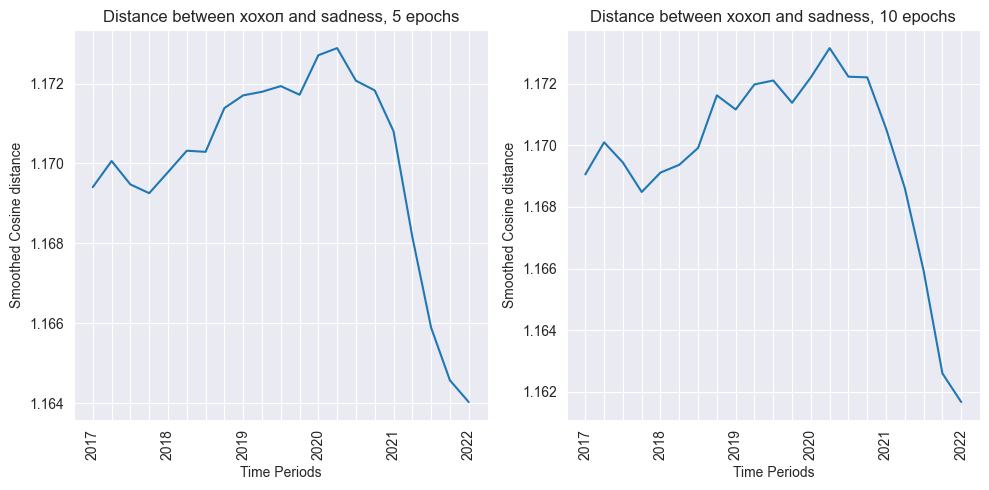

In [628]:
plot_all_concept('хохол', lists_dict['sadnessrus'], 'sadness')

['хохлом', 'хохлов', 'хохла', 'хохлу', 'хохлам', 'хохлы', 'хохлах', 'хохол', 'хохле', 'хохлами']
********************************************************************************
['', 'шантажированные', 'дискриминация', 'свалках', 'ворчала', 'понепростительнее', 'понепокорнее', 'разрушителе', 'наказанная', 'грубость', 'хлопаемые', 'врагом', 'наиподлейшего', 'отменяем', 'причинять', 'защиту', 'шумов', 'бессмысленнейших', 'гашенными', 'хищно']
['хохлом', 'хохлов', 'хохла', 'хохлу', 'хохлам', 'хохлы', 'хохлах', 'хохол', 'хохле', 'хохлами']
********************************************************************************
['', 'шантажированные', 'дискриминация', 'свалках', 'ворчала', 'понепростительнее', 'понепокорнее', 'разрушителе', 'наказанная', 'грубость', 'хлопаемые', 'врагом', 'наиподлейшего', 'отменяем', 'причинять', 'защиту', 'шумов', 'бессмысленнейших', 'гашенными', 'хищно']


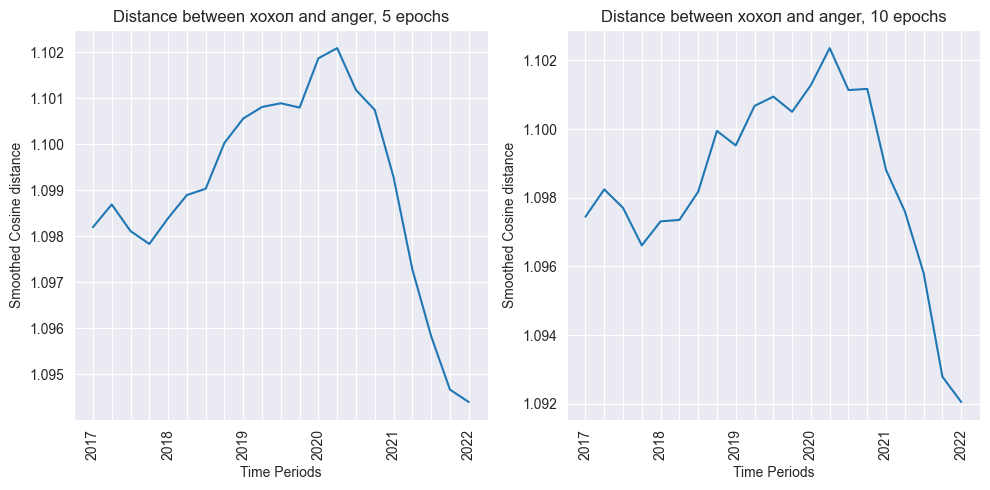

In [629]:
plot_all_concept('хохол', lists_dict['angerrus'], 'anger')

['хохлом', 'хохлов', 'хохла', 'хохлу', 'хохлам', 'хохлы', 'хохлах', 'хохол', 'хохле', 'хохлами']
********************************************************************************
['', 'правящую', 'разъяснёнными', 'почтениях', 'посмеиваются', 'поручениях', 'обнимающей', 'составляем', 'приходом', 'сплочена', 'выздоровление', 'оживим', 'дополняема', 'полулежавшем', 'наполняющей', 'наклоняешь', 'защиту', 'сторожащему', 'умнейшем', 'моногамиях']
['хохлом', 'хохлов', 'хохла', 'хохлу', 'хохлам', 'хохлы', 'хохлах', 'хохол', 'хохле', 'хохлами']
********************************************************************************
['', 'правящую', 'разъяснёнными', 'почтениях', 'посмеиваются', 'поручениях', 'обнимающей', 'составляем', 'приходом', 'сплочена', 'выздоровление', 'оживим', 'дополняема', 'полулежавшем', 'наполняющей', 'наклоняешь', 'защиту', 'сторожащему', 'умнейшем', 'моногамиях']


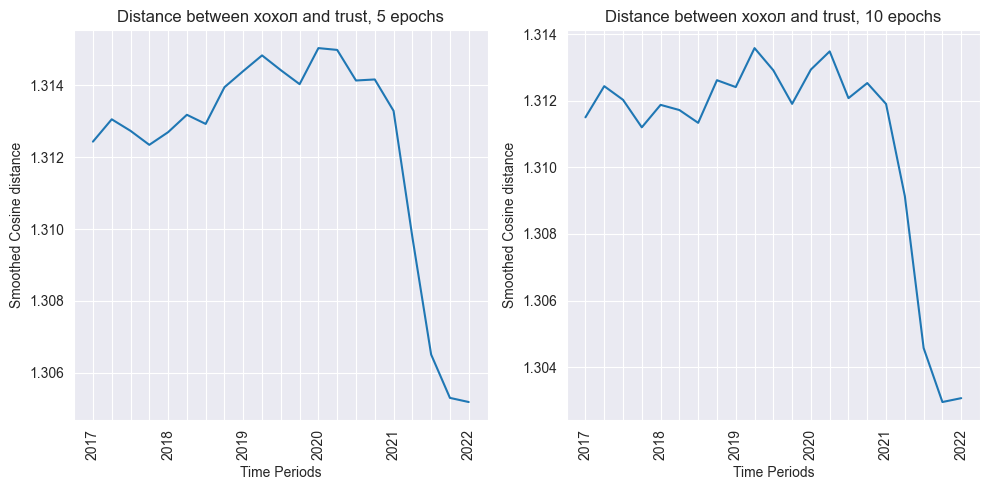

In [630]:
plot_all_concept('хохол', lists_dict['trustrus'], 'trust')


['укронацистом', 'укронацист', 'укронацисту', 'укронацистов', 'укронациста', 'укронацисты', 'укронацисте', 'укронацистами', 'укронацистам', 'укронацистах']
********************************************************************************
['', 'дискриминация', 'тошноты', 'ворчала', 'понепростительнее', 'понепокорнее', 'извратит', 'наказанная', 'непристойному', 'врагом', 'дефектное', 'наиподлейшего', 'падонка', 'раздувшем', 'волосатейшем', 'флигель', 'термиту', 'шумов', 'бессмысленнейших', 'желатине']
['укронацистом', 'укронацист', 'укронацисту', 'укронацистов', 'укронациста', 'укронацисты', 'укронацисте', 'укронацистами', 'укронацистам', 'укронацистах']
********************************************************************************
['', 'дискриминация', 'тошноты', 'ворчала', 'понепростительнее', 'понепокорнее', 'извратит', 'наказанная', 'непристойному', 'врагом', 'дефектное', 'наиподлейшего', 'падонка', 'раздувшем', 'волосатейшем', 'флигель', 'термиту', 'шумов', 'бессмысленнейших', 'жел

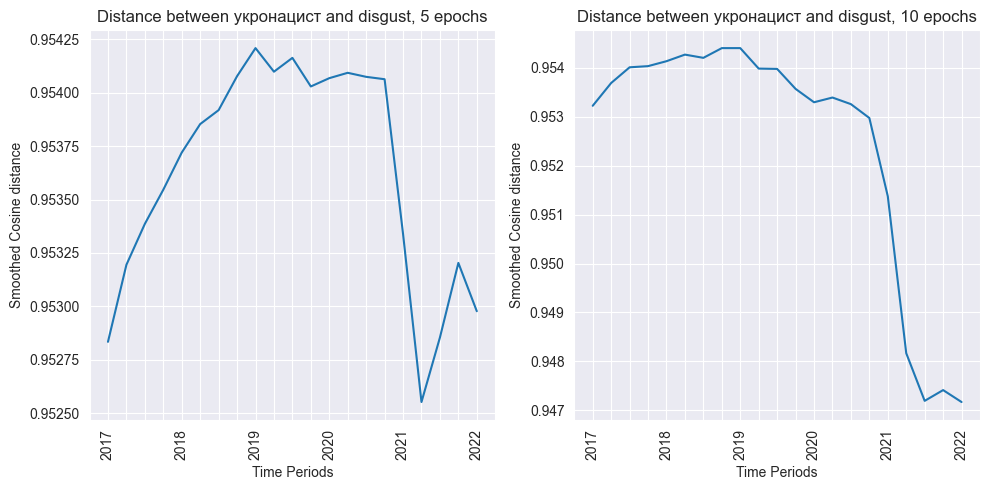

In [668]:
plot_all_concept('укронацист', lists_dict['disgustrus'], 'disgust')

['укронацистом', 'укронацист', 'укронацисту', 'укронацистов', 'укронациста', 'укронацисты', 'укронацисте', 'укронацистами', 'укронацистам', 'укронацистах']
********************************************************************************
['', 'шантажированные', 'правящую', 'наиопаснейшими', 'дискриминация', 'отсутствуйте', 'похоронившее', 'кораблекрушеньях', 'разрушителе', 'наказанная', 'грубость', 'загадочное', 'хлопаемые', 'врагом', 'наиподлейшего', 'депортируемых', 'загадочна', 'бронируемый', 'убежищ', 'причинять']
['укронацистом', 'укронацист', 'укронацисту', 'укронацистов', 'укронациста', 'укронацисты', 'укронацисте', 'укронацистами', 'укронацистам', 'укронацистах']
********************************************************************************
['', 'шантажированные', 'правящую', 'наиопаснейшими', 'дискриминация', 'отсутствуйте', 'похоронившее', 'кораблекрушеньях', 'разрушителе', 'наказанная', 'грубость', 'загадочное', 'хлопаемые', 'врагом', 'наиподлейшего', 'депортируемых', 'зага

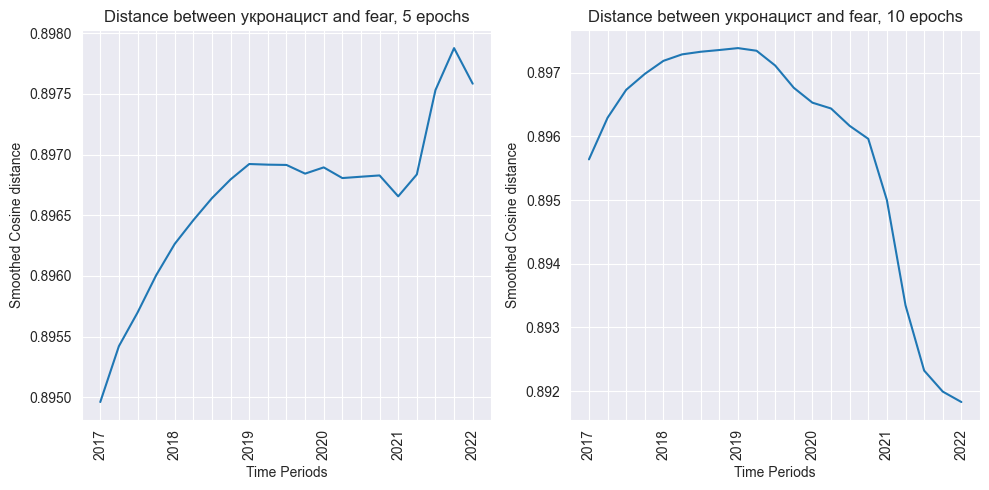

In [660]:
plot_all_concept('укронацист', lists_dict['fearrus'], 'fear')

['укронацистом', 'укронацист', 'укронацисту', 'укронацистов', 'укронациста', 'укронацисты', 'укронацисте', 'укронацистами', 'укронацистам', 'укронацистах']
********************************************************************************
['', 'наиопаснейшими', 'дискриминация', 'свалках', 'отсутствуйте', 'похоронившее', 'кораблекрушеньях', 'понепростительнее', 'наказанная', 'понеспособней', 'вылет изшая', 'депортируемых', 'потерянное', 'апатичным', 'причинять', 'бессмысленнейших', 'спойлерами', 'хищно', 'невнимательные', 'скорбишь']
['укронацистом', 'укронацист', 'укронацисту', 'укронацистов', 'укронациста', 'укронацисты', 'укронацисте', 'укронацистами', 'укронацистам', 'укронацистах']
********************************************************************************
['', 'наиопаснейшими', 'дискриминация', 'свалках', 'отсутствуйте', 'похоронившее', 'кораблекрушеньях', 'понепростительнее', 'наказанная', 'понеспособней', 'вылет изшая', 'депортируемых', 'потерянное', 'апатичным', 'причинять',

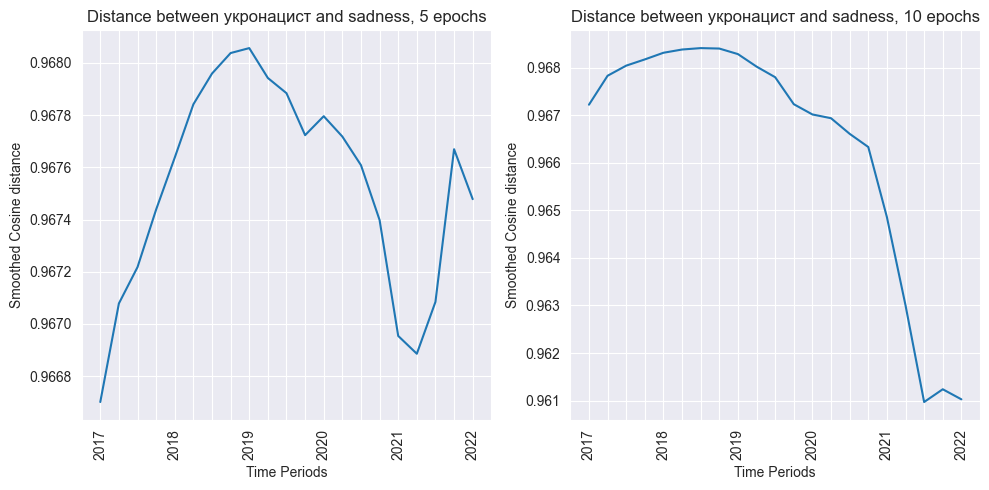

In [663]:
plot_all_concept('укронацист', lists_dict['sadnessrus'], 'sadness')

['укронацистом', 'укронацист', 'укронацисту', 'укронацистов', 'укронациста', 'укронацисты', 'укронацисте', 'укронацистами', 'укронацистам', 'укронацистах']
********************************************************************************
['', 'шантажированные', 'дискриминация', 'свалках', 'ворчала', 'понепростительнее', 'понепокорнее', 'разрушителе', 'наказанная', 'грубость', 'хлопаемые', 'врагом', 'наиподлейшего', 'отменяем', 'причинять', 'защиту', 'шумов', 'бессмысленнейших', 'гашенными', 'хищно']
['укронацистом', 'укронацист', 'укронацисту', 'укронацистов', 'укронациста', 'укронацисты', 'укронацисте', 'укронацистами', 'укронацистам', 'укронацистах']
********************************************************************************
['', 'шантажированные', 'дискриминация', 'свалках', 'ворчала', 'понепростительнее', 'понепокорнее', 'разрушителе', 'наказанная', 'грубость', 'хлопаемые', 'врагом', 'наиподлейшего', 'отменяем', 'причинять', 'защиту', 'шумов', 'бессмысленнейших', 'гашенными', '

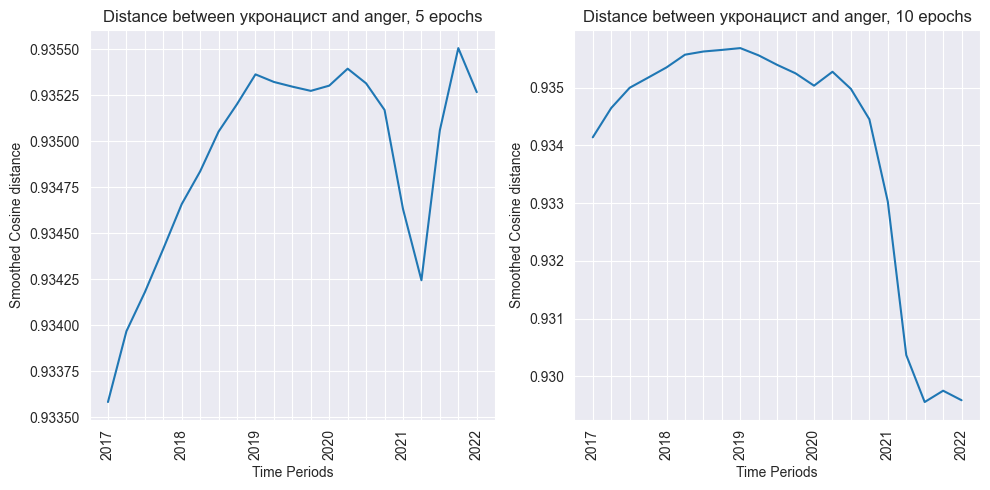

In [662]:
plot_all_concept('укронацист', lists_dict['angerrus'], 'anger')

['укронацистом', 'укронацист', 'укронацисту', 'укронацистов', 'укронациста', 'укронацисты', 'укронацисте', 'укронацистами', 'укронацистам', 'укронацистах']
********************************************************************************
['', 'правящую', 'разъяснёнными', 'почтениях', 'посмеиваются', 'поручениях', 'обнимающей', 'составляем', 'приходом', 'сплочена', 'выздоровление', 'оживим', 'дополняема', 'полулежавшем', 'наполняющей', 'наклоняешь', 'защиту', 'сторожащему', 'умнейшем', 'моногамиях']
['укронацистом', 'укронацист', 'укронацисту', 'укронацистов', 'укронациста', 'укронацисты', 'укронацисте', 'укронацистами', 'укронацистам', 'укронацистах']
********************************************************************************
['', 'правящую', 'разъяснёнными', 'почтениях', 'посмеиваются', 'поручениях', 'обнимающей', 'составляем', 'приходом', 'сплочена', 'выздоровление', 'оживим', 'дополняема', 'полулежавшем', 'наполняющей', 'наклоняешь', 'защиту', 'сторожащему', 'умнейшем', 'моногам

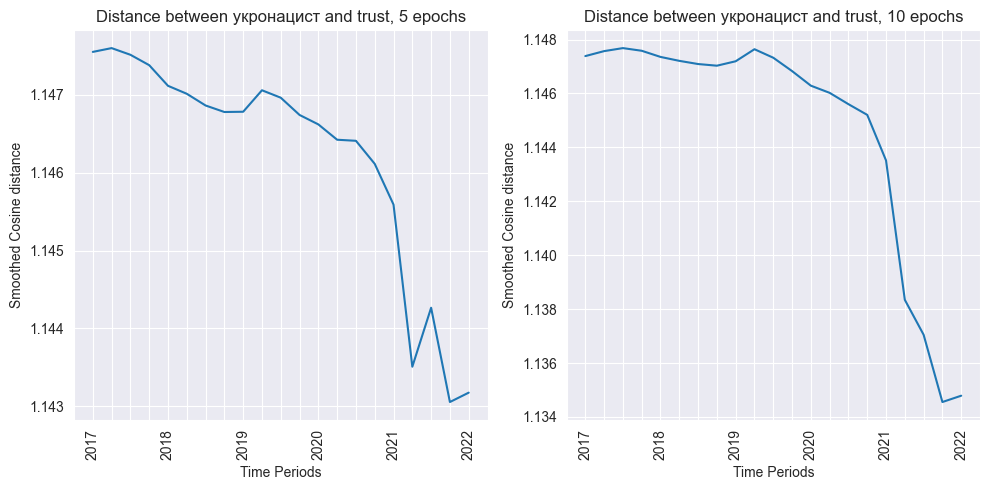

In [661]:
plot_all_concept('укронацист', lists_dict['trustrus'], 'trust')

['укропитеку', 'укропитек', 'укропитекам', 'укропитеке', 'укропитеках', 'укропитеками', 'укропитеков', 'укропитеки', 'укропитека', 'укропитеком']
********************************************************************************
['', 'дискриминация', 'тошноты', 'ворчала', 'понепростительнее', 'понепокорнее', 'извратит', 'наказанная', 'непристойному', 'врагом', 'дефектное', 'наиподлейшего', 'падонка', 'раздувшем', 'волосатейшем', 'флигель', 'термиту', 'шумов', 'бессмысленнейших', 'желатине']
['укропитеку', 'укропитек', 'укропитекам', 'укропитеке', 'укропитеках', 'укропитеками', 'укропитеков', 'укропитеки', 'укропитека', 'укропитеком']
********************************************************************************
['', 'дискриминация', 'тошноты', 'ворчала', 'понепростительнее', 'понепокорнее', 'извратит', 'наказанная', 'непристойному', 'врагом', 'дефектное', 'наиподлейшего', 'падонка', 'раздувшем', 'волосатейшем', 'флигель', 'термиту', 'шумов', 'бессмысленнейших', 'желатине']


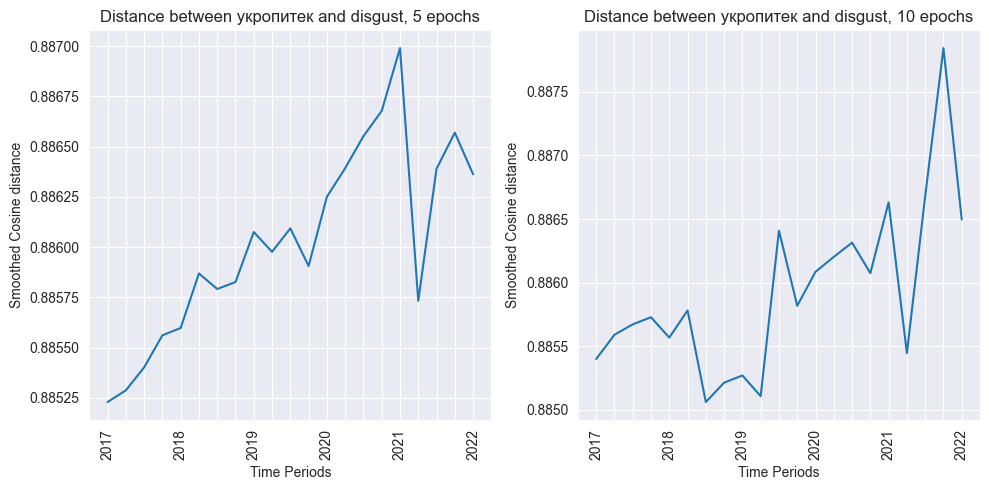

In [669]:
plot_all_concept('укропитек', lists_dict['disgustrus'], 'disgust')

['укропитеку', 'укропитек', 'укропитекам', 'укропитеке', 'укропитеках', 'укропитеками', 'укропитеков', 'укропитеки', 'укропитека', 'укропитеком']
********************************************************************************
['', 'шантажированные', 'правящую', 'наиопаснейшими', 'дискриминация', 'отсутствуйте', 'похоронившее', 'кораблекрушеньях', 'разрушителе', 'наказанная', 'грубость', 'загадочное', 'хлопаемые', 'врагом', 'наиподлейшего', 'депортируемых', 'загадочна', 'бронируемый', 'убежищ', 'причинять']
['укропитеку', 'укропитек', 'укропитекам', 'укропитеке', 'укропитеках', 'укропитеками', 'укропитеков', 'укропитеки', 'укропитека', 'укропитеком']
********************************************************************************
['', 'шантажированные', 'правящую', 'наиопаснейшими', 'дискриминация', 'отсутствуйте', 'похоронившее', 'кораблекрушеньях', 'разрушителе', 'наказанная', 'грубость', 'загадочное', 'хлопаемые', 'врагом', 'наиподлейшего', 'депортируемых', 'загадочна', 'бронируемый

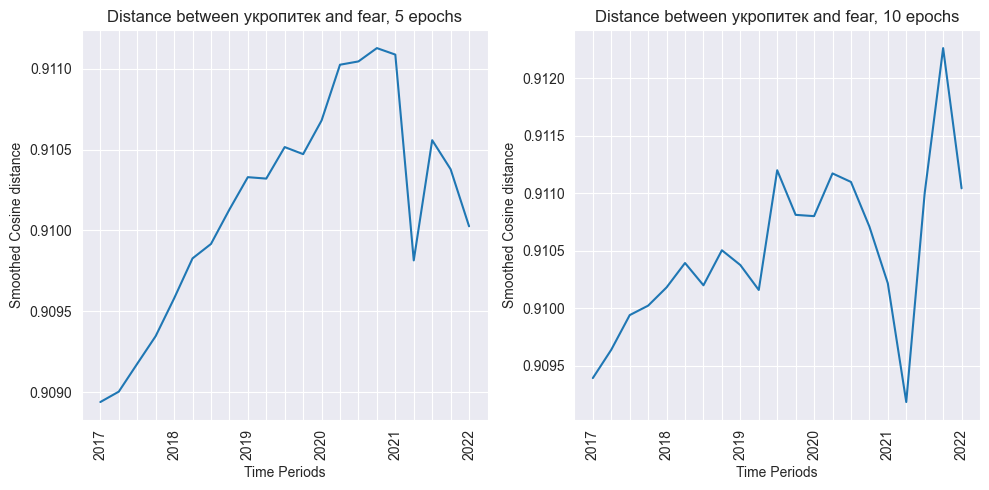

In [670]:
plot_all_concept('укропитек', lists_dict['fearrus'], 'fear')